<a href="https://colab.research.google.com/github/sameh999/NLP-project/blob/main/NLP_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start
---


In [ ]:
import requests
import re
import random
from nltk.stem import *
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords,gutenberg
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import ShuffleSplit,KFold,cross_val_score,train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
import matplotlib.pyplot as mtp    
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score
from tqdm import tqdm
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from scipy import sparse
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics.pairwise import euclidean_distances
import pylab
%matplotlib inline
#___________________________________
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Functions

In [ ]:
def get_book(url):
    book = requests.get(url).content.decode("utf-8")
    return book

In [ ]:
def remove_punct(book):
    # Remove Punctuation using regex
    return re.sub(r'[^\w\s]','', book)

In [ ]:
def remove_numbers(book):
    # Remove Punctuation using regex
    return re.sub('[^A-Za-z]+', ' ', book)

In [ ]:
def remove_stopwords(book):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    return pattern.sub('', book.lower())

In [ ]:
def split_book(book):
    # Split book to 150 words
    book_words = book.split()
    n = 150
    parts = [(book_words[i*n : (i+1)*n]) for i in range((len(book_words)+ n-1)//n)]
    
    # Split book to paragraphs
    book_list = []
    for part in parts[:-1]:
        book_list.append([" ".join(part)])
    del book_list[0:1]  
    # Select 200 random paragraphs from the book
    random_200 = random.sample(book_list, 200)
    
    return random_200

In [ ]:
def parts_into_df(parts_list, label):
    df = pd.DataFrame(parts_list, columns=['Paragraphs'])
    # add label
    df['Label'] = label
    # add index
    df['Index'] = range(1, len(df)+1)
    
    return df

## The 5 books 

Title  | Author | Genre | Link
----------------|-----------------|------------------|------------------
1. The Pirates of Ersatz | Murray Leinster | Science Fiction | https://www.gutenberg.org/ebooks/24035 
2. How it Works | Archibald Williams | Technology | https://www.gutenberg.org/ebooks/28553
3. Surgical Anatomy | Joseph Maclise | Medicine | https://www.gutenberg.org/ebooks/24440
4. Quick and easy cooking |  Crocker, Betty | Food | https://www.gutenberg.org/files/62841/62841-0.txt
5. Fifty Years In The Northwest | William H. C. Folsom | Travel | https://www.gutenberg.org/ebooks/36375


## Main

### Creating the dataframe

In [ ]:

urls = ['https://www.gutenberg.org/cache/epub/24035/pg24035.txt', 
 'https://www.gutenberg.org/cache/epub/28553/pg28553.txt', 
 'https://www.gutenberg.org/ebooks/24440.txt.utf-8', 
 'https://www.gutenberg.org/files/61719/61719-0.txt', 
 'https://www.gutenberg.org/cache/epub/36375/pg36375.txt']


lables = ['a', 'b', 'c', 'd', 'e']

url_label = list(zip(urls, lables))
[(url, label) for url, label in url_label]

[('https://www.gutenberg.org/cache/epub/24035/pg24035.txt', 'a'),
 ('https://www.gutenberg.org/cache/epub/28553/pg28553.txt', 'b'),
 ('https://www.gutenberg.org/ebooks/24440.txt.utf-8', 'c'),
 ('https://www.gutenberg.org/files/61719/61719-0.txt', 'd'),
 ('https://www.gutenberg.org/cache/epub/36375/pg36375.txt', 'e')]

In [ ]:
books_dict={}
books_dict={"book"+str(index+1):parts_into_df(split_book(remove_stopwords(remove_numbers(remove_punct(get_book(url))))), label= label) 
        for index,(url, label) in enumerate(url_label)} 

In [ ]:
# concatenate all dataframe books
books_df = pd.concat([books_dict[book] for book in books_dict])
#books_df =  books_df.sample(frac = 1)

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Paragraphs  1000 non-null   object
 1   Label       1000 non-null   object
 2   Index       1000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 31.2+ KB


In [ ]:
books_df.Label.unique()

array(['a', 'b', 'c', 'd', 'e'], dtype=object)

In [ ]:
# save to csv file
books_df.to_csv('books_df.csv', index=False)

In [ ]:
books_df = pd.read_csv('books_df.csv')
books_df.tail(3)

Paragraphs Label  Index
997  francis kelly clinton boardman l beebe beal br...     e    198
998  hardwood small portion brush prairie easily re...     e    199
999  reuben f little clear lake pineville frank nye...     e    200

## Exploratory Data Analysis

In [ ]:
def plot_word_cloud(book1):
  book1_str = [" ".join(doc) for doc in book1]
  
  #convert it to dictionary with values and its occurences
  word_could_dict=Counter(",".join(book1_str).split())
  wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

In [ ]:
def plot_word_bar(book): 

  book1_str = [" ".join(doc) for doc in book]
  
  #convert it to dictionary with values and its occurences
  word_could_dict=Counter(",".join(book1_str).split())

  plt.figure(figsize=(15,8))
  plt.bar(range(len(word_could_dict.most_common(20))), [val[1] for val in word_could_dict.most_common(20)], align='center')
  plt.xticks(range(len(word_could_dict.most_common(20))), [val[0] for val in word_could_dict.most_common(20)])
  plt.xticks(rotation=70)
  plt.title("Most Frequent Words")
  plt.xlabel("Word")
  plt.ylabel("Count")
  plt.show()

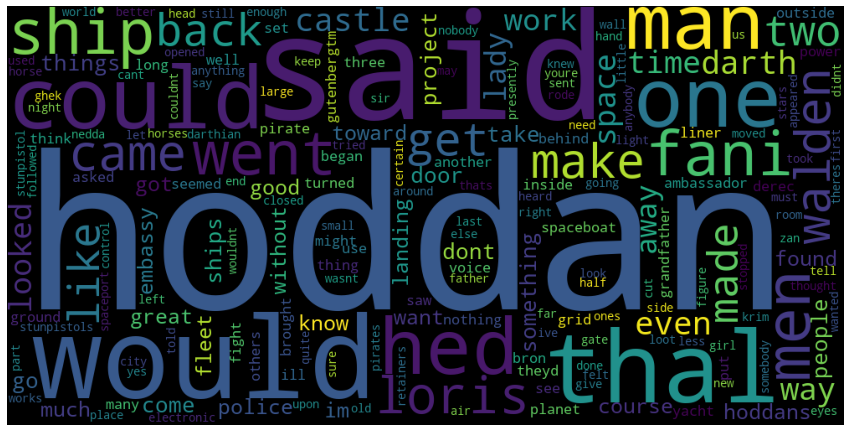

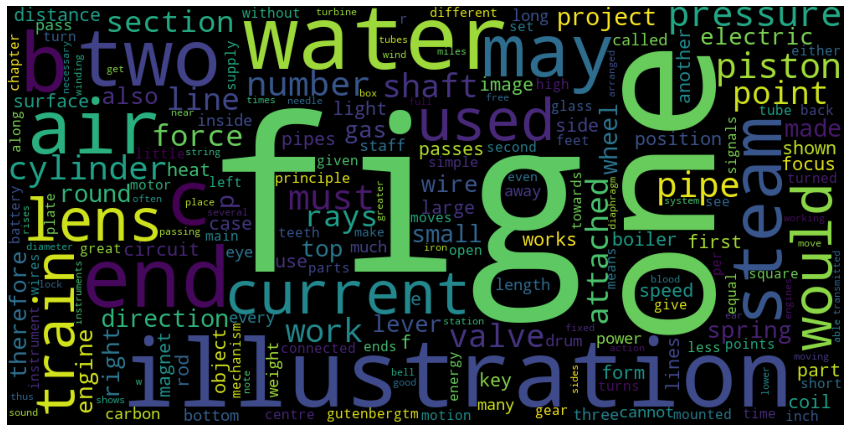

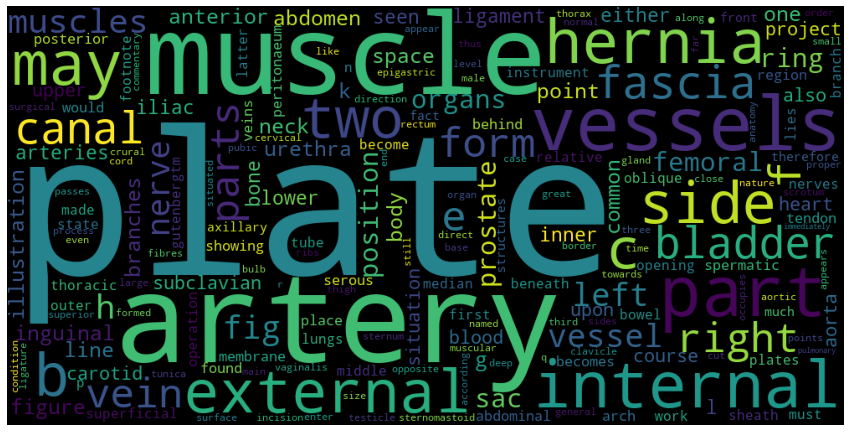

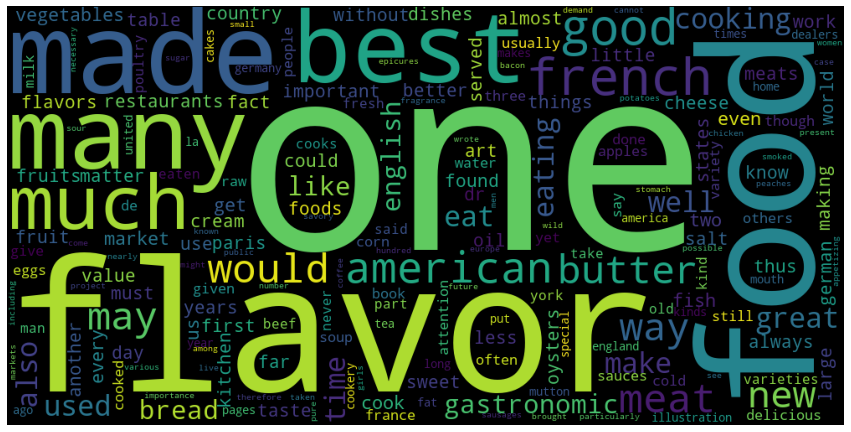

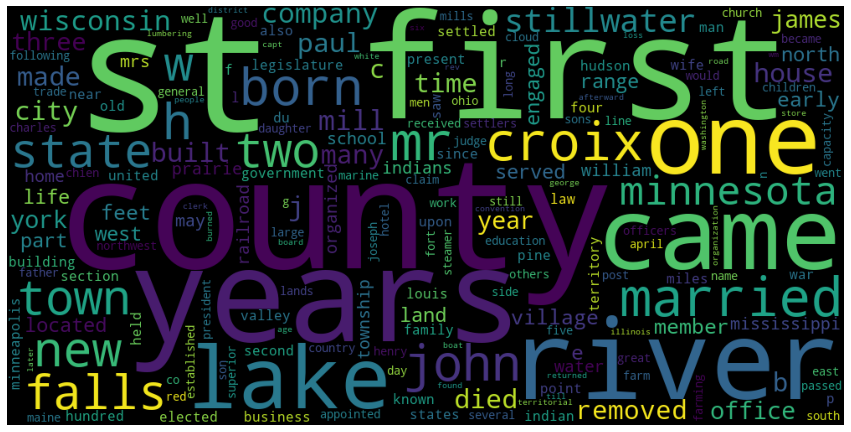

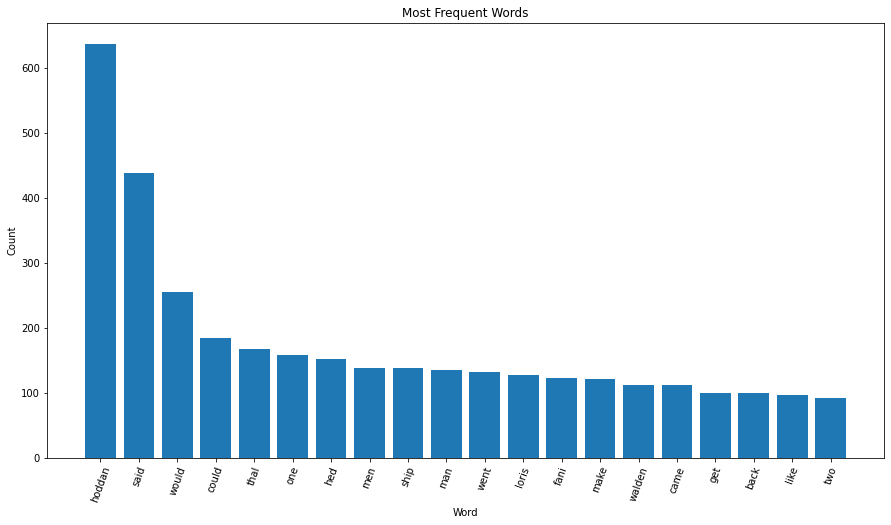

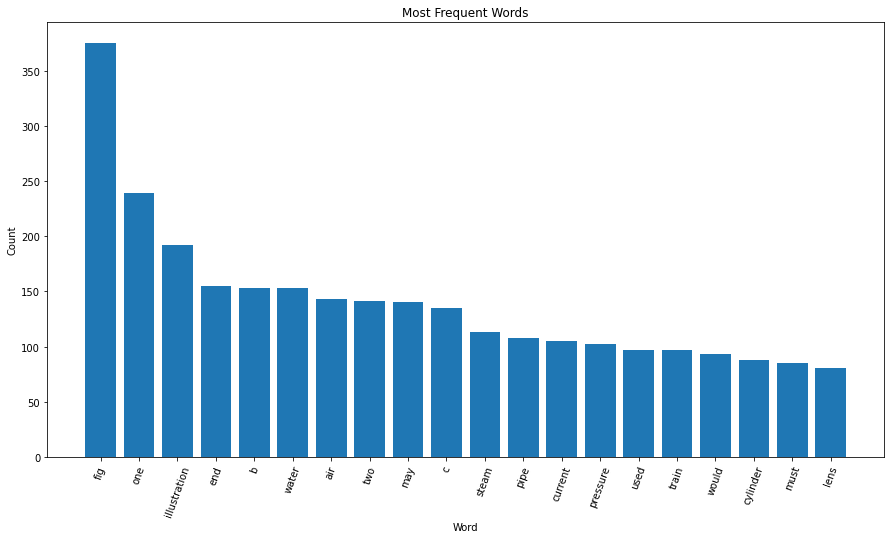

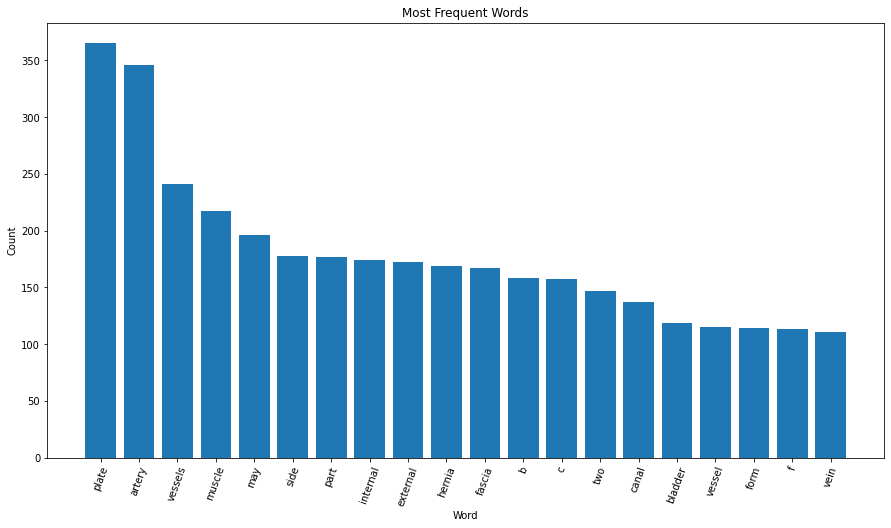

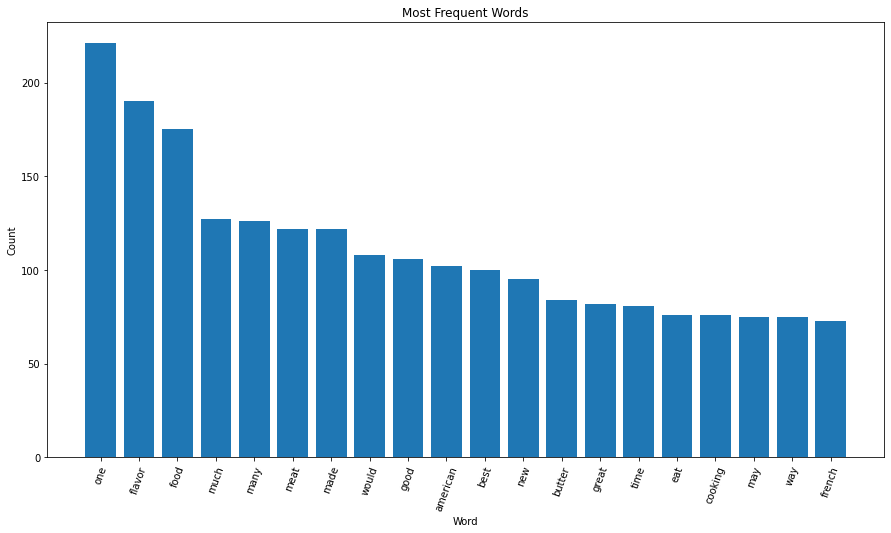

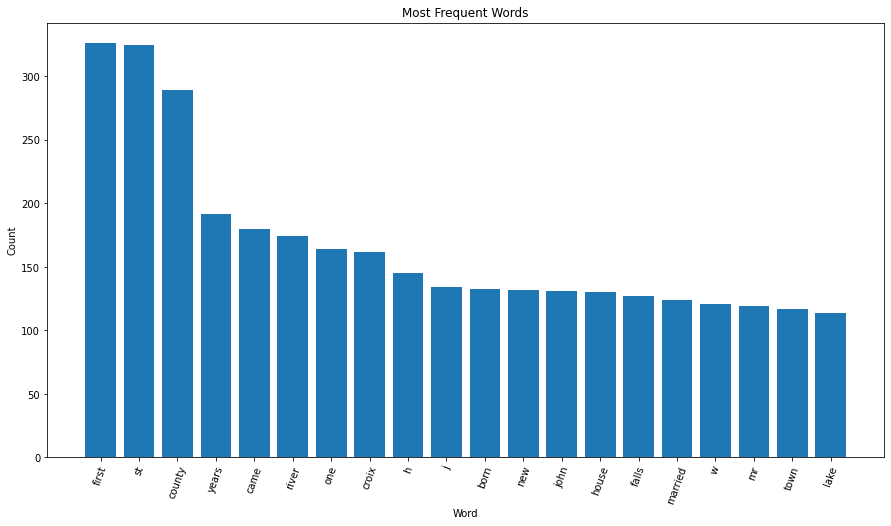

In [ ]:
for url in urls:
  plot_word_cloud(split_book(remove_stopwords(remove_numbers(remove_punct(get_book(url))))))
for url in urls:
  plot_word_bar(split_book(remove_stopwords(remove_numbers(remove_punct(get_book(url))))))

## Data Transformation

In [ ]:
books_df = pd.read_csv('books_df.csv')

#### BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

ngram1_vectorizer_obj = CountVectorizer(analyzer='word', ngram_range=(1, 1)) # , max_features=200
ngram1_vectorizer_model = ngram1_vectorizer_obj.fit_transform(books_df.iloc[:,0])
ngram1_vectorizer_names = ngram1_vectorizer_obj.get_feature_names()

features1_df = pd.DataFrame(ngram1_vectorizer_model.toarray() ,columns = ngram1_vectorizer_names)
bag_of_word1= features1_df
print("Data dimensions before PCA with BOW:",bag_of_word1.shape)

count =ngram1_vectorizer_obj.fit_transform(books_df.iloc[:,0]).todense()
bag_of_word1
#perform PCA to plot 
pca = PCA(n_components=2)
pca.fit(count)
BOW_2Dtransformed_data=pca.transform(count)
print("Data dimensions after PCA with BOW:",BOW_2Dtransformed_data.shape)
#print(BOW_2Dtransformed_data)

Data dimensions before PCA with BOW: (1000, 19913)
Data dimensions after PCA with BOW: (1000, 2)


#### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_obj = TfidfVectorizer()
tfidf_pickle = tfidf_obj.fit(books_df.iloc[:,0])
tfidf_model = tfidf_obj.fit_transform(books_df.iloc[:,0])
tfidf_obj_names = tfidf_obj.get_feature_names()

tfidf_df1 = pd.DataFrame(tfidf_model.toarray(), columns=tfidf_obj_names)
#tfidf_df1

print("Data dimensions before PCA with BOW:",tfidf_df1.shape)

count =tfidf_obj.fit_transform(books_df.iloc[:,0]).todense()
tfidf_df1
#perform PCA to plot 
pca = PCA(n_components=2)
pca.fit(count)
tfidf_2Dtransformed_data=pca.transform(count)
print("Data dimensions after PCA with BOW:",tfidf_2Dtransformed_data.shape)
tfidf_df1

Data dimensions before PCA with BOW: (1000, 19913)
Data dimensions after PCA with BOW: (1000, 2)


aaa  aaah  aal  aaron  ...  zungenragout  zwiebeln  zygoma  zygomatic
0    0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
1    0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
2    0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
3    0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
4    0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
..   ...   ...  ...    ...  ...           ...       ...     ...        ...
995  0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
996  0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
997  0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
998  0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0
999  0.0   0.0  0.0    0.0  ...           0.0       0.0     0.0        0.0

[1000 rows x 19913 columns]

#### LDA

In [ ]:
#LDA Transform
from sklearn.decomposition import LatentDirichletAllocation
count_vect = CountVectorizer()
X_t = count_vect.fit_transform(books_df.iloc[:,0]).todense()
lda = LatentDirichletAllocation(n_components=5,random_state=0) 
LDA_out= lda.fit_transform( X_t)
print("Data dimensions before PCA with LDA and BOW:",LDA_out.shape)
#perform PCA to plot 
pca = PCA(n_components=2)
pca.fit(LDA_out)
LDA_2Dtransformed_data=pca.transform(LDA_out)
print("Data dimensions after PCA with LDA and BOW:",LDA_2Dtransformed_data.shape)
print(LDA_2Dtransformed_data)

Data dimensions before PCA with LDA and BOW: (1000, 5)
Data dimensions after PCA with LDA and BOW: (1000, 2)
[[-0.28244911  0.52253547]
 [-0.21482941  0.81663915]
 [-0.21910471  0.80175492]
 ...
 [-0.59617455 -0.50859509]
 [-0.50127924 -0.39514889]
 [-0.59610858 -0.50855262]]


#### Word Embedding 

(1000, 50)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).


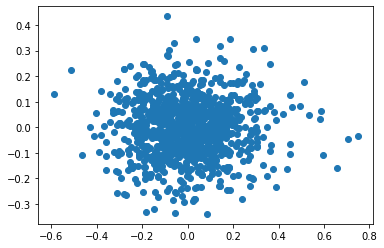

In [ ]:
# make word2vec and apply in document 
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

docs = [d for d in books_df['Paragraphs']]
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]

vec_size = 50
alpha = 0.025
d2v_model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.0025,
                min_count=1,
                dm =1)
d2v_model.build_vocab(documents)
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
d2v=d2v_model.docvecs.doctag_syn0
#print(d2v)
print(d2v.shape)
pca = PCA(n_components=2)
result = pca.fit_transform(d2v)
plt.scatter(result[:, 0], result[:, 1])

### plot model

In [ ]:
def plot_BOW(y_predict, title_m ):
      
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 0, 0], BOW_2Dtransformed_data[y_predict == 0, 1], s = 200, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 1, 0], BOW_2Dtransformed_data[y_predict == 1, 1], s = 200, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 2, 0], BOW_2Dtransformed_data[y_predict == 2, 1], s = 200, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 3, 0], BOW_2Dtransformed_data[y_predict == 3, 1], s = 200, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 4, 0], BOW_2Dtransformed_data[y_predict == 4, 1], s = 200, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 0, 0]), np.mean( BOW_2Dtransformed_data[y_predict == 0, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 1, 0]), np.mean(BOW_2Dtransformed_data[y_predict == 1, 1],), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 2, 0]), np.mean(BOW_2Dtransformed_data[y_predict == 2, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 3, 0]), np.mean(BOW_2Dtransformed_data[y_predict == 3, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 4, 0]), np.mean(BOW_2Dtransformed_data[y_predict == 4, 1]), color='yellow', marker='^', markersize=12)
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  


In [ ]:
def plot_TF_IDF(y_predict, title_m ):
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==0,0], tfidf_2Dtransformed_data[pred_y ==0,1] ,c='magenta' ,label='claster 1')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==1,0], tfidf_2Dtransformed_data[pred_y ==1,1] ,c= 'green',label='claster 1')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==2,0], tfidf_2Dtransformed_data[pred_y ==2,1] ,c= 'blue',label='claster 3')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==3,0], tfidf_2Dtransformed_data[pred_y ==3,1] ,c= 'orange',label='claster 4')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==4,0], tfidf_2Dtransformed_data[pred_y ==4,1] ,c= 'cyan',label='claster 5')
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 0, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 0, 1]), color='yellow', marker='^', markersize=12)
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 1, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 1, 1],), color='yellow', marker='^', markersize=12)
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 2, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 2, 1]), color='yellow', marker='^', markersize=12)
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 3, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 3, 1]), color='yellow', marker='^', markersize=12)
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 4, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 4, 1]), color='yellow', marker='^', markersize=12)
   mtp.title(title_m )  
   mtp.legend()  
   mtp.show()  

In [ ]:
def plot_LDA(y_predict, title_m ):
      
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 0, 0], LDA_2Dtransformed_data[y_predict == 0, 1], s = 100, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 1, 0], LDA_2Dtransformed_data[y_predict == 1, 1], s = 100, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 2, 0], LDA_2Dtransformed_data[y_predict == 2, 1], s = 100, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 3, 0], LDA_2Dtransformed_data[y_predict == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 4, 0], LDA_2Dtransformed_data[y_predict == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 0, 0]), np.mean( LDA_2Dtransformed_data[y_predict == 0, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 1, 0]), np.mean(LDA_2Dtransformed_data[y_predict == 1, 1],), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 2, 0]), np.mean(LDA_2Dtransformed_data[y_predict == 2, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 3, 0]), np.mean(LDA_2Dtransformed_data[y_predict == 3, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 4, 0]), np.mean(LDA_2Dtransformed_data[y_predict == 4, 1]), color='yellow', marker='^', markersize=12)
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  

In [ ]:

def plot_word__em(y_predict, title_m ):
      
    mtp.scatter(result[y_predict == 0, 0], result[y_predict == 0, 1], s = 100, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(result[y_predict == 1, 0], result[y_predict == 1, 1], s = 100, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(result[y_predict == 2, 0], result[y_predict == 2, 1], s = 100, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(result[y_predict == 3, 0], result[y_predict == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(result[y_predict == 4, 0], result[y_predict == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.plot(np.mean(result[y_predict == 0, 0]), np.mean( result[y_predict == 0, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(result[y_predict == 1, 0]), np.mean(result[y_predict == 1, 1],), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(result[y_predict == 2, 0]), np.mean(result[y_predict == 2, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(result[y_predict == 3, 0]), np.mean(result[y_predict == 3, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(result[y_predict == 4, 0]), np.mean(result[y_predict == 4, 1]), color='yellow', marker='^', markersize=12)
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  

###get coherance of the cluster of model and  true data to make evaluation 

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# Enable logging for gensim - optional
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

book_doc = books_df['Paragraphs'].values.tolist()
doc_list =[]
for doc in book_doc:
  doc_list.append(doc.split())
print(doc_list)
# Create a dictionary representation of the documents.
dictionary = Dictionary(doc_list)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in doc_list]
# View
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print([[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]])
lda_model =LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=5, 
                    random_state=100,
                    update_every=1,
                    chunksize=100,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)      
cm = CoherenceModel(model =lda_model,texts=doc_list,corpus=corpus,coherence='c_v')
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_lda = cm.get_coherence()
print('\nCoherence Score: ', round(coherence_lda, 4))

[['filled', 'dense', 'white', 'mist', 'free', 'temporarily', 'around', 'lay', 'capital', 'city', 'waldenthe', 'highest', 'civilization', 'part', 'galaxy', 'trees', 'lined', 'ways', 'towers', 'rose', 'splendidly', 'toward', 'skies', 'thousands', 'less', 'ambitious', 'structures', 'open', 'squares', 'parkways', 'malls', 'smell', 'like', 'city', 'wasnt', 'loose', 'three', 'minutes', 'communicator', 'truck', 'squawked', 'allpolice', 'alarm', 'expected', 'city', 'would', 'shortly', 'one', 'enormous', 'mantrap', 'set', 'catch', 'bron', 'hoddan', 'one', 'place', 'planet', 'fact', 'could', 'safeand', 'wouldnt', 'safe', 'hed', 'officially', 'charged', 'murder', 'since', 'police', 'tactfully', 'failed', 'mention', 'murder', 'could', 'get', 'least', 'breathingtime', 'taking', 'refuge', 'interstellar', 'embassy', 'headed', 'bowling', 'along', 'splendidly', 'police', 'truck', 'hummed', 'way', 'half', 'mile', 'threequarters', 'great', 'open', 'square', 'embassy', 'became', 'visible', 'embassy', 'sin

In [ ]:
# #!pip install pyLDAvis

# import pyLDAvis
# import pyLDAvis.gensim_models

# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
# vis

# Helmy
---


##K-mean with BOW

In [ ]:
bow__helmy = bag_of_word1
tfidf_helmy = tfidf_df1
helmy_lda =  LDA_out
helmy_word_vec =d2v


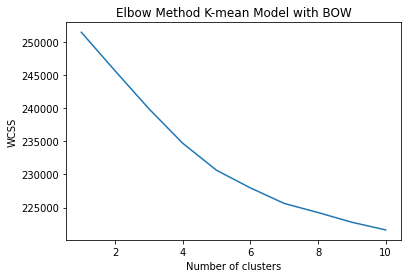

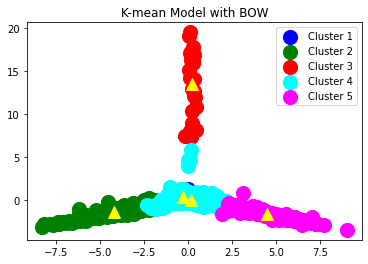



Accuracy equal :->  0.71
              precision    recall  f1-score   support

           a       1.00      0.86      0.93       200
           b       0.99      0.88      0.93       200
           c       0.32      0.04      0.08       200
           d       0.42      0.99      0.59       200
           e       1.00      0.78      0.87       200

    accuracy                           0.71      1000
   macro avg       0.75      0.71      0.68      1000
weighted avg       0.75      0.71      0.68      1000

Kappa for the model :->  0.6375
For n_clusters = 5 The average silhouette_score : 0.026480270455698666
For n_clusters = 5 The average homogeneity_score : 0.6207501407501969
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 3 3 1 1 3 1 1 1 3 1 1 1 1 1 1 1 1 2 1 1 3 1 2 1 1 1 1
 1 1 1 1 1 

In [ ]:
# applay K-mean with BOW
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=40, random_state=7)
    kmeans.fit(bow__helmy)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method K-mean Model with BOW')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=140, random_state=7)
pred_y= kmeans.fit_predict(bow__helmy)  
plot_BOW( pred_y ,'K-mean Model with BOW')
# get accuricy of model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(1)
  elif yy[i]=="b":
    x.append(2)
  elif yy[i]=="c":
    x.append(4)
  elif yy[i]=="d":
    x.append(3)
  else :
    x.append(0)

print("Accuracy equal :-> ",np.mean(pred_y == x))
print(metrics.classification_report( x , pred_y,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(pred_y,x))
silhouette_avg = silhouette_score(bow__helmy,pred_y)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,pred_y)) 

print(pred_y)

##K-mean with TF-IDF 

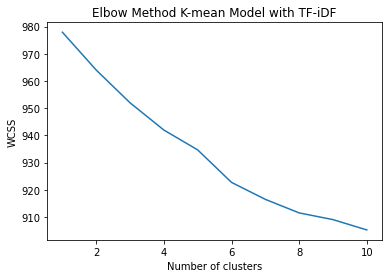

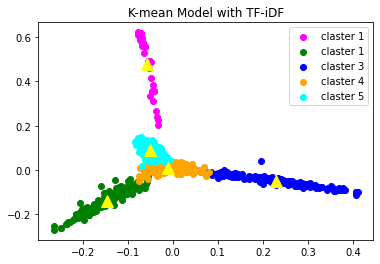



Accuracy equal :->  0.739
              precision    recall  f1-score   support

           a       0.09      0.01      0.03       200
           b       0.99      0.94      0.97       200
           c       1.00      0.93      0.96       200
           d       0.45      0.95      0.61       200
           e       1.00      0.86      0.93       200

    accuracy                           0.74      1000
   macro avg       0.71      0.74      0.70      1000
weighted avg       0.71      0.74      0.70      1000

Kappa for the model :->  0.6737500000000001
For n_clusters = 5 The average silhouette_score : 0.027326077366437957
For n_clusters = 5 The average homogeneity_score : 0.7100268721794665
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 

In [ ]:
# apply the k-mean on TF-IDF data transformation 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tfidf_helmy)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method K-mean Model with TF-iDF')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=150, random_state=7)
pred_y = kmeans.fit_predict(tfidf_helmy)
plot_TF_IDF( pred_y ,'K-mean Model with TF-iDF')
# get accuricy of model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(1)
  elif yy[i]=="b":
    x.append(3)
  elif yy[i]=="c":
    x.append(2)
  elif yy[i]=="d":
    x.append(0)
  else :
    x.append(4)
#print(yy )
#print(y_prediction )

print("Accuracy equal :-> ",metrics.accuracy_score(pred_y,x))
print(metrics.classification_report( x , pred_y,target_names= names ))

print("Kappa for the model :-> " , cohen_kappa_score(pred_y,x))

silhouette_avg = silhouette_score(tfidf_helmy , pred_y)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,pred_y)) 

print(kmeans.labels_)


##k-mean with lda

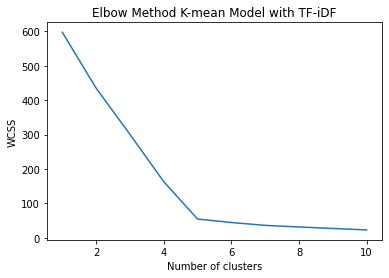

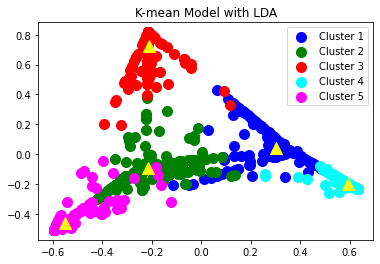



Accuracy equal :->  0.936
              precision    recall  f1-score   support

           a       0.92      0.94      0.93       200
           b       0.94      0.95      0.95       200
           c       0.98      0.95      0.97       200
           d       0.86      0.93      0.89       200
           e       0.98      0.92      0.95       200

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Kappa for the model :->  0.92
For n_clusters = 5 The average silhouette_score : 0.02154024637190152
For n_clusters = 5 The average homogeneity_score : 0.8325899797500119
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 3 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2 2 2 2
 2 2 2 2 2 3 

In [ ]:
# apply the k-mean on lad data transformation 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(helmy_lda)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method K-mean Model with LDA')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=150, random_state=7)
pred_y = kmeans.fit_predict(helmy_lda)

plot_LDA( pred_y ,'K-mean Model with LDA')
# get accuricy of model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(2)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(3)
  elif yy[i]=="d":
    x.append(1)
  else :
    x.append(4)

print("Accuracy equal :-> ",metrics.accuracy_score(pred_y,x))
print(metrics.classification_report( x , pred_y,target_names= names ))

print("Kappa for the model :-> " , cohen_kappa_score(pred_y,x))

silhouette_avg = silhouette_score(tfidf_helmy , pred_y)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,pred_y)) 

print(pred_y)


##k-mean with word to vec

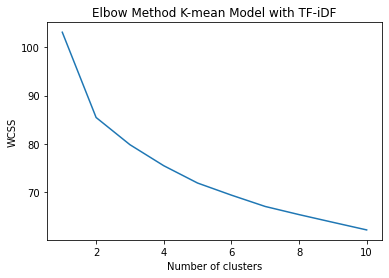

[2 4 2 1 3 1 3 4 4 1 0 3 3 1 4 0 3 0 0 0 3 2 3 4 2 0 0 0 2 0 4 1 4 2 0 3 3
 0 4 0 3 0 2 3 1 0 2 3 3 4 3 1 2 2 4 0 4 2 1 0 0 3 1 4 0 3 2 2 1 3 3 4 2 0
 4 2 3 0 0 1 3 3 4 3 4 2 2 1 0 4 4 0 4 0 0 2 3 0 1 2 4 2 0 4 4 2 0 0 2 3 1
 0 4 3 3 2 0 0 1 4 3 3 2 4 0 2 3 4 2 0 0 0 4 0 4 2 1 0 1 3 1 3 0 1 3 3 1 0
 3 3 3 3 3 2 3 2 2 1 3 1 0 0 0 3 0 3 0 2 1 1 3 0 0 3 0 0 0 2 3 0 0 2 3 3 2
 4 0 4 3 3 2 0 2 0 0 1 1 4 2 0 2 3 2 3 0 2 2 3 2 1 4 1 3 2 0 2 2 1 3 2 2 4
 1 3 2 2 2 2 2 3 4 0 3 3 0 3 3 0 3 3 1 3 2 3 0 3 0 3 3 3 3 3 0 4 2 0 2 2 4
 2 2 3 4 2 3 0 3 1 2 0 1 0 3 4 3 2 2 3 1 0 1 2 1 4 0 2 3 0 3 3 1 4 3 4 2 1
 0 3 1 2 1 1 0 0 2 2 3 3 3 3 2 3 3 1 2 1 0 0 3 0 3 0 3 1 4 1 0 4 2 3 2 3 2
 2 2 4 4 4 0 1 3 2 0 3 0 0 1 4 4 3 0 3 2 3 2 1 2 0 2 2 4 3 0 0 1 1 4 1 3 0
 3 1 1 3 3 3 3 2 4 1 0 4 0 0 0 0 2 0 3 3 0 1 0 4 0 3 3 1 0 1 2 2 3 2 2 3 3
 2 2 3 1 1 2 2 2 3 2 1 2 1 1 2 1 3 1 2 3 2 3 0 0 3 2 3 2 3 1 3 0 3 1 2 1 2
 2 2 1 3 2 3 0 3 1 2 3 1 0 3 0 1 2 2 2 3 0 0 3 1 2 1 2 1 4 1 3 0 0 0 0 1 1
 1 3 3 0 4 3 3 2 0 3 1 3 

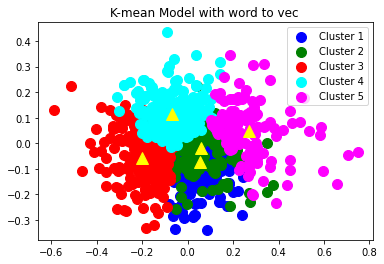



Accuracy equal :->  0.178
              precision    recall  f1-score   support

           a       0.23      0.29      0.26       200
           b       0.38      0.15      0.22       400
           c       0.22      0.23      0.22       200
           d       0.00      0.00      0.00         0
           e       0.10      0.07      0.08       200

    accuracy                           0.18      1000
   macro avg       0.18      0.15      0.16      1000
weighted avg       0.26      0.18      0.20      1000

Kappa for the model :->  -0.0071061014457241
For n_clusters = 5 The average silhouette_score : 0.08634387
For n_clusters = 5 The average homogeneity_score : 0.019091556796966953


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# apply the k-mean on word to vec data transformation 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(helmy_word_vec)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method K-mean Model with word to vec')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=50, random_state=7)
pred_y = kmeans.fit_predict(helmy_word_vec)
print(pred_y)
plot_word__em( pred_y ,'K-mean Model with word to vec ')
#model_accuricy(helmy_word_vec,y_predict)
# get accuricy of model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(1)
  elif yy[i]=="b":
    x.append(2)
  elif yy[i]=="c":
    x.append(4)
  elif yy[i]=="d":
    x.append(0)
  else :
    x.append(1)
#print(yy )
#print(y_prediction )

print("Accuracy equal :-> ",metrics.accuracy_score(pred_y,x))
print(metrics.classification_report( x , pred_y,target_names= names ))

print("Kappa for the model :-> " , cohen_kappa_score(pred_y,x))

silhouette_avg = silhouette_score(helmy_word_vec , pred_y)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,pred_y)) 


# Sameh
---


In [ ]:
bow__sameh = bag_of_word1
fidf_sameh = tfidf_df1
lda_sameh = LDA_out
sameh_word_vec =d2v

In [ ]:
# apply GaussianMixture on BOW on and make predicton 
def EM_model(X):
  n_components = np.arange(1, 10)
  models = [GaussianMixture(n, covariance_type='diag', random_state=0).fit(X) for n in n_components]
  plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
  plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
  plt.legend(loc='best')
  plt.xlabel('n_components');
  plt.show()  

  GM = GaussianMixture(n_components=5, covariance_type='spherical', random_state=7)
  GM.fit(X)

  y_pred = GM.predict(X)
  return y_pred


###apply GaussianMixture on BOW on and make predicton

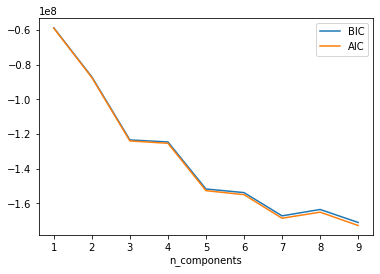

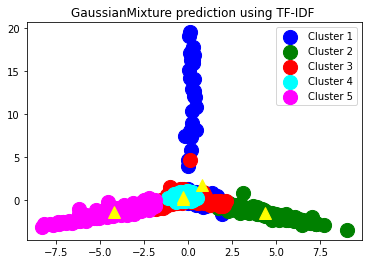



Accuracy equal :->  0.832
              precision    recall  f1-score   support

           a       0.73      0.79      0.76       200
           b       1.00      0.80      0.89       200
           c       0.63      0.94      0.75       200
           d       1.00      0.76      0.86       200
           e       0.99      0.88      0.93       200

    accuracy                           0.83      1000
   macro avg       0.87      0.83      0.84      1000
weighted avg       0.87      0.83      0.84      1000

Kappa for the model :->  0.79
For n_clusters = 5 The average silhouette_score : 0.0037163555507610784
For n_clusters = 5 The average homogeneity_score : 0.6597246681500907
[4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 0 4 4 4 4 4
 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 2 4 4 4 4 4 4 2 2 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4
 4 4 4 4 4 4 4 4 4 2 2 2 4 4 2 4 4 4 2 4 4 4 4 4 4 4 4 0 4 4 2 4 0 4 4 4 4
 4 4 4 4 4 

In [ ]:
label = EM_model(bow__sameh)
plot_BOW(label , 'GaussianMixture prediction using BoW' )
#model_accuricy(bow__sameh ,label)
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(4)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(1)
  elif yy[i]=="d":
    x.append(2)
  else :
    x.append(3)
#print(yy )
#print(y_prediction )

print("Accuracy equal :-> ",metrics.accuracy_score(label,x))
print(metrics.classification_report( x , label,target_names= names ))

print("Kappa for the model :-> " , cohen_kappa_score(label,x))

silhouette_avg = silhouette_score(bow__sameh , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)


###apply GaussianMixture on TF-IDF on and make predicton 

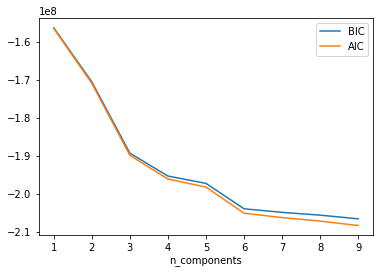

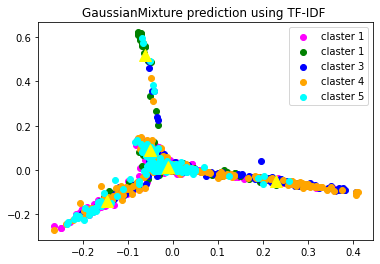



Accuracy equal :->  0.744
              precision    recall  f1-score   support

           a       0.45      0.96      0.62       200
           b       1.00      0.93      0.96       200
           c       0.07      0.01      0.02       200
           d       0.99      0.94      0.96       200
           e       1.00      0.89      0.94       200

    accuracy                           0.74      1000
   macro avg       0.70      0.74      0.70      1000
weighted avg       0.70      0.74      0.70      1000

Kappa for the model :->  0.6799999999999999
For n_clusters = 5 The average silhouette_score : 0.026886977227255273
For n_clusters = 5 The average homogeneity_score : 0.7142107600611104
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2 3 3 3 

In [ ]:
# apply GaussianMixture on TF-IDF on and make predicton 
label =EM_model(fidf_sameh)
plot_TF_IDF(label , 'GaussianMixture prediction using TF-IDF ' )

# get accurecy
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(3)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(1)
  elif yy[i]=="d":
    x.append(2)
  else :
    x.append(4)

print("Accuracy equal :-> ",metrics.accuracy_score(label,x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(fidf_sameh , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

### apply GaussianMixture on LDA data  on and make predicton 


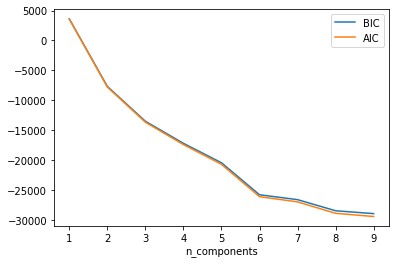

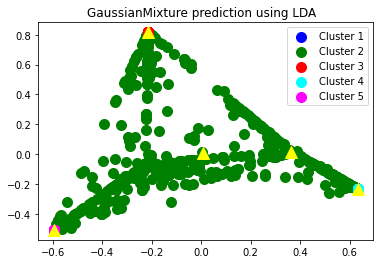



Accuracy equal :->  0.577
              precision    recall  f1-score   support

           a       1.00      0.42      0.60       200
           b       0.33      0.98      0.49       200
           c       1.00      0.50      0.67       200
           d       0.76      0.36      0.49       200
           e       1.00      0.62      0.77       200

    accuracy                           0.58      1000
   macro avg       0.82      0.58      0.60      1000
weighted avg       0.82      0.58      0.60      1000

Kappa for the model :->  0.47124999999999995
For n_clusters = 5 The average silhouette_score : 0.2056197807451466
For n_clusters = 5 The average homogeneity_score : 0.37486740335628255
[1 2 1 1 2 1 1 2 2 1 1 1 2 1 2 2 2 2 2 2 1 1 2 2 3 2 1 1 2 2 1 3 2 1 1 1 1
 2 1 1 2 2 1 2 1 1 1 2 1 2 1 2 1 1 2 1 2 1 2 1 1 1 2 1 2 2 2 1 2 2 1 2 2 2
 1 1 2 1 2 1 1 2 2 1 2 2 2 2 2 1 2 2 1 1 2 3 2 2 1 2 2 2 1 1 2 1 1 2 1 1 2
 2 1 2 1 1 2 2 1 1 1 1 1 2 2 2 2 2 1 1 1 1 2 2 1 2 2 2 3 1 2 1 2 3 2 1 1 

In [ ]:
# apply GaussianMixture on LDA data  on and make predicton 
label = EM_model(lda_sameh)
plot_LDA(label , 'GaussianMixture prediction using LDA  ' )

# get accurecy
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(2)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(3)
  elif yy[i]=="d":
    x.append(1)
  else :
    x.append(4)

print("Accuracy equal :-> ",metrics.accuracy_score(label,x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(lda_sameh , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

###apply GaussianMixture on word embeded on and make predicton 

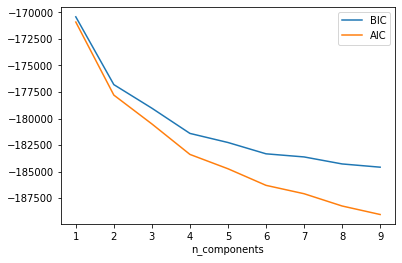

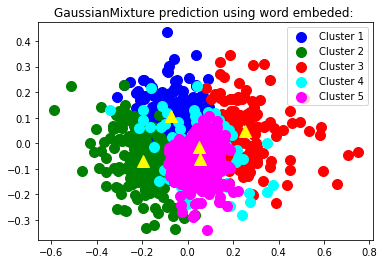



Accuracy equal :->  0.224
              precision    recall  f1-score   support

           a       0.22      0.27      0.24       200
           b       0.29      0.31      0.30       200
           c       0.27      0.20      0.23       200
           d       0.23      0.12      0.16       200
           e       0.16      0.22      0.18       200

    accuracy                           0.22      1000
   macro avg       0.23      0.22      0.22      1000
weighted avg       0.23      0.22      0.22      1000

Kappa for the model :->  0.030000000000000027
For n_clusters = 5 The average silhouette_score : 0.07754373
For n_clusters = 5 The average homogeneity_score : 0.01846319285574072
[1 2 1 2 0 3 0 2 2 4 2 2 0 4 2 4 0 4 4 4 0 1 0 2 3 4 4 4 0 2 2 3 2 1 4 0 0
 4 2 4 0 4 4 0 3 4 1 0 0 2 0 3 1 1 4 4 2 1 4 4 4 0 3 2 4 0 1 1 0 0 0 2 1 4
 2 1 0 4 4 3 0 0 2 0 2 1 1 4 1 2 2 4 2 4 4 1 0 4 4 0 2 1 2 2 2 1 4 4 0 0 4
 4 2 0 0 1 4 4 1 4 1 0 1 2 4 1 0 2 1 4 4 4 2 4 2 1 4 4 3 0 4 0 2 3 0 0 3 4
 2 0 

In [ ]:
# apply GaussianMixture on word embeded on and make predicton 
label = EM_model(sameh_word_vec)
plot_word__em(label , 'GaussianMixture prediction using word embeded: ' )
# get accurecy of the model 
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(0)
  elif yy[i]=="b":
    x.append(4)
  elif yy[i]=="c":
    x.append(1)
  elif yy[i]=="d":
    x.append(2)
  else :
    x.append(3)

print("Accuracy equal :-> ",np.mean(label == x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(sameh_word_vec , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

# Mostafa
---


#### Hierarchy Functions

In [ ]:
def dist_matrix(features):
  dist_matrix = euclidean_distances(features, features) 
  Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')
  return Z_using_dist_matrix  

def draw_dendo(Z_using_dist_matrix):  
  fig = pylab.figure(figsize=(18,50))
  dendro = hierarchy.dendrogram(Z_using_dist_matrix, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [ ]:
# def agglom_model(dist_mat, n_clusters): 
#   agglom = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'complete')
#   model = agglom.fit(dist_mat)

#   return model

##### Transformation Functions

In [ ]:
def bow_transform(corpus):
    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(corpus)
    return X, vectorizer

In [ ]:
def tfidf_transform(corpus):
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(corpus)
    return X, vectorizer

In [ ]:
def lda_transform(corpus):
  vectorizer = LatentDirichletAllocation(n_components = 5, max_iter=10, n_jobs = -1, batch_size=128, learning_decay=0.5, random_state=0)
  X = vectorizer.fit_transform(corpus)  
  return sparse.csr_matrix(X), vectorizer

##### Plot Functions

In [ ]:
def plot_clusters(transform_model, cluster_model, y, n=5):
    # PCA for Transformation model
    pca_model = PCA(n_components=2).fit_transform(transform_model.toarray())
    
    plt.figure(figsize=(17,6))
    
    plt.subplot(1,2,1)
    for clstr in range(n):
        x_points_org = pca_model[y == clstr, 0]
        y_points_org = pca_model[y == clstr, 1]
        plt.scatter(x_points_org, y_points_org, label='Book '+str(clstr+1))
        plt.plot(np.mean(x_points_org), np.mean(y_points_org), color='yellow', marker='^', markersize=12)
    
    plt.title("Original Data")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    
    plt.subplot(1,2,2)
    for clstr in range(n):
        x_points = pca_model[cluster_model.fit_predict(pca_model) == clstr, 0]
        y_points = pca_model[cluster_model.fit_predict(pca_model) == clstr, 1]
        plt.scatter(x_points, y_points, label="Cluster "+str(clstr+1))
        plt.plot(np.mean(x_points), np.mean(y_points), color='yellow', marker='^', markersize=12)
    
    plt.title("Clusters")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend();

##### Metrics Functions

In [ ]:
def calc_scores(transformation_model, clustering_model, y):
  silh = silhouette_score(transformation_model.toarray(), clustering_model.fit_predict(transformation_model.toarray()))
  kap = cohen_kappa_score(y, clustering_model.labels_)

  print("Silhouette Coefficient is:", round(silh, 3))
  print("Cohen’s kappa Score is:", round(kap, 4))

In [ ]:
books_df['label_num'] = books_df.Label.map({'a':0, 'b':1, 'c':2, 'd':3, 'e':4})
y = books_df.label_num

### BoW

In [ ]:
bow_model, bow_vectorizer = bow_transform(books_df.Paragraphs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


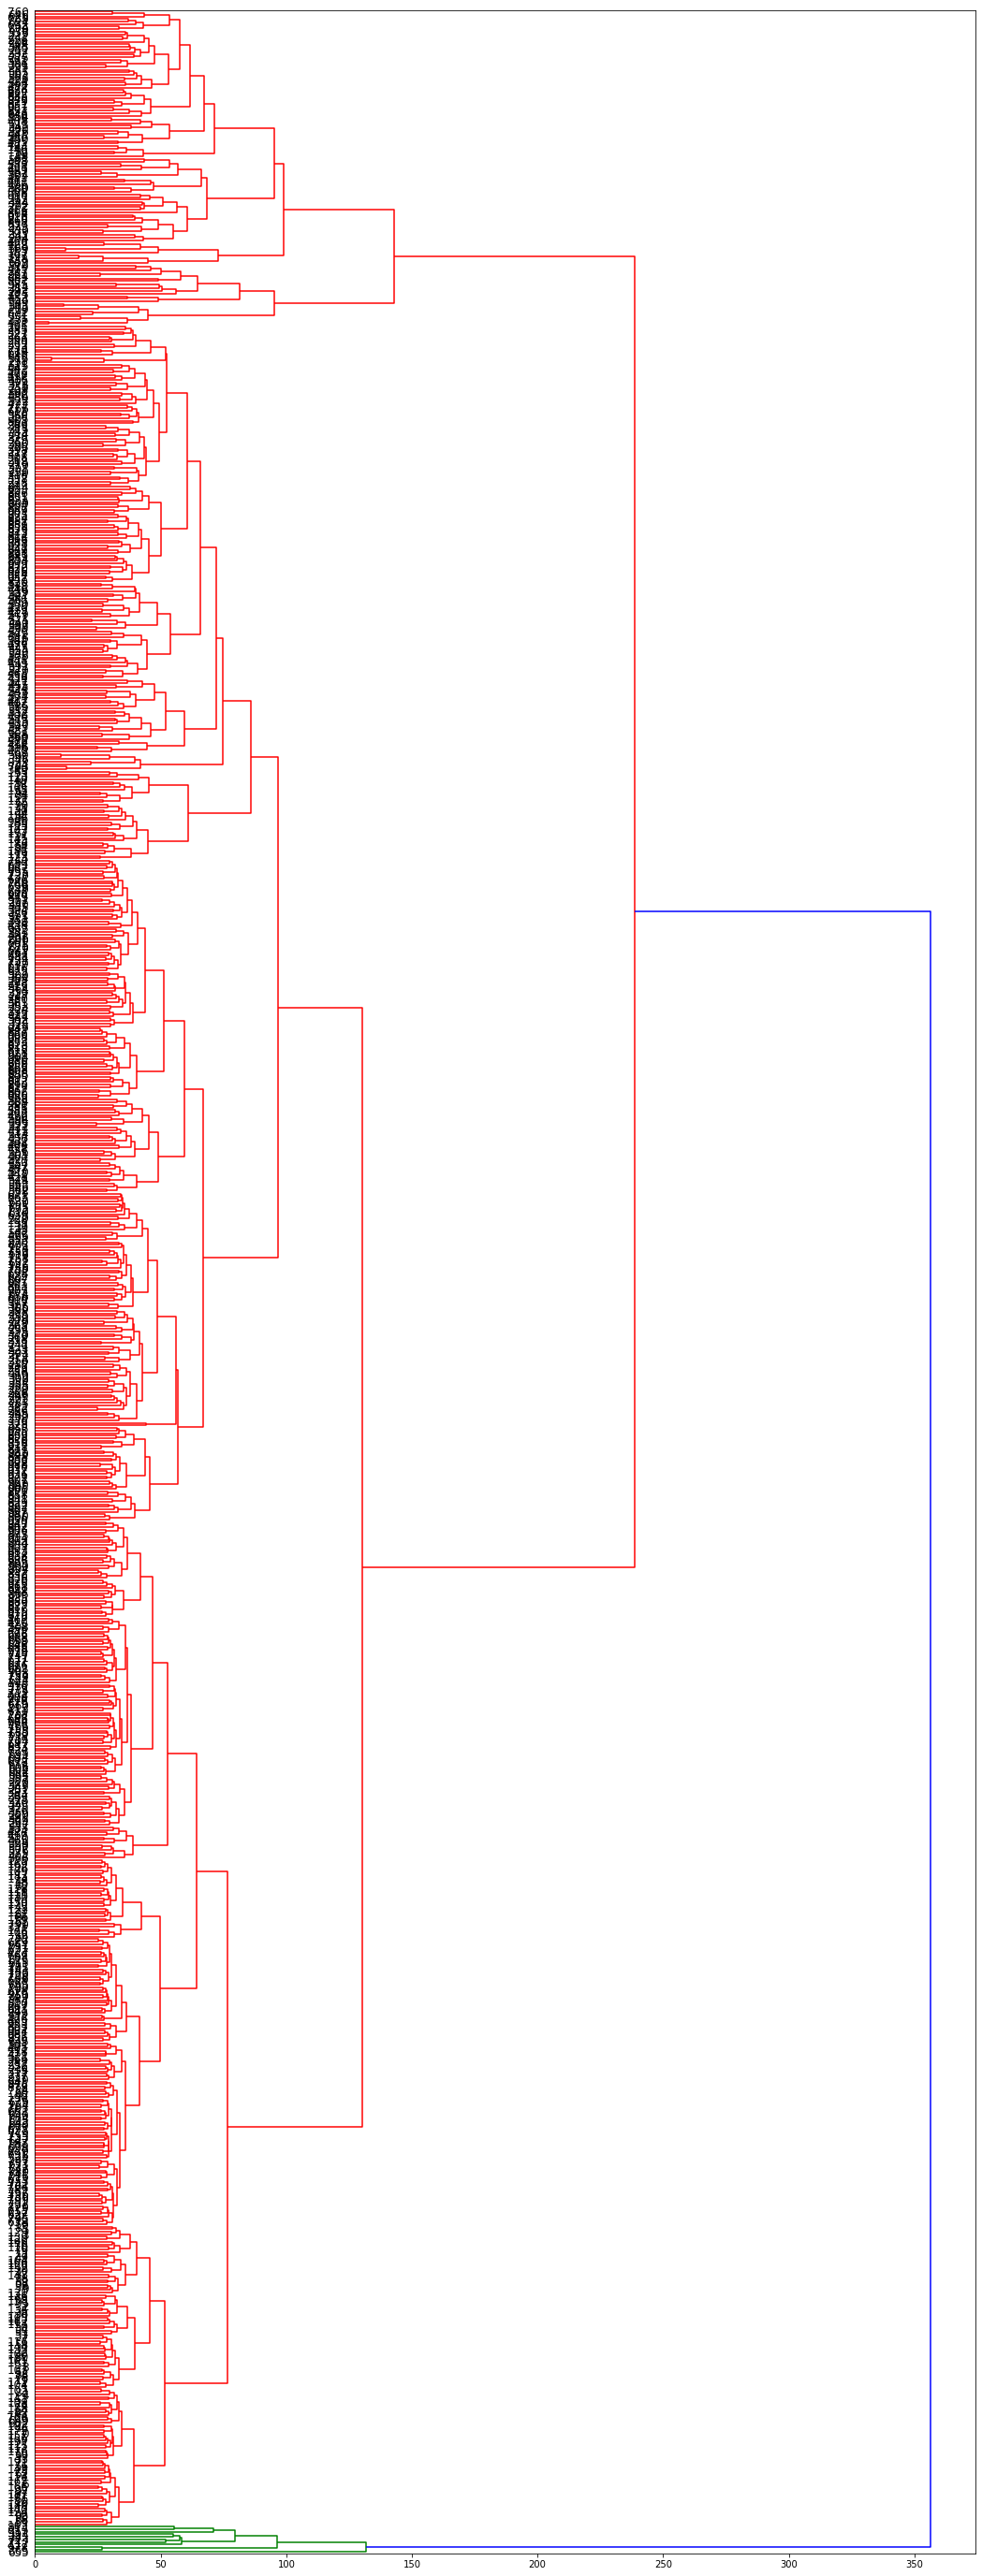

In [ ]:
draw_dendo(dist_matrix(bow_model))

In [ ]:
agg_bow_model = AgglomerativeClustering(n_clusters=5).fit(bow_model.toarray(), y)
#agg_bow_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)



Accuracy equal :->  0.764
              precision    recall  f1-score   support

           a       0.48      0.95      0.63       200
           b       0.99      0.97      0.98       200
           c       1.00      0.95      0.97       200
           d       0.11      0.01      0.03       200
           e       1.00      0.94      0.97       200

    accuracy                           0.76      1000
   macro avg       0.71      0.76      0.72      1000
weighted avg       0.71      0.76      0.72      1000

Kappa for the model :->  0.7050000000000001
For n_clusters = 5 The average silhouette_score : 0.024700578084067185
For n_clusters = 5 The average homogeneity_score : 0.7624909612013824
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 3 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2 2 2 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


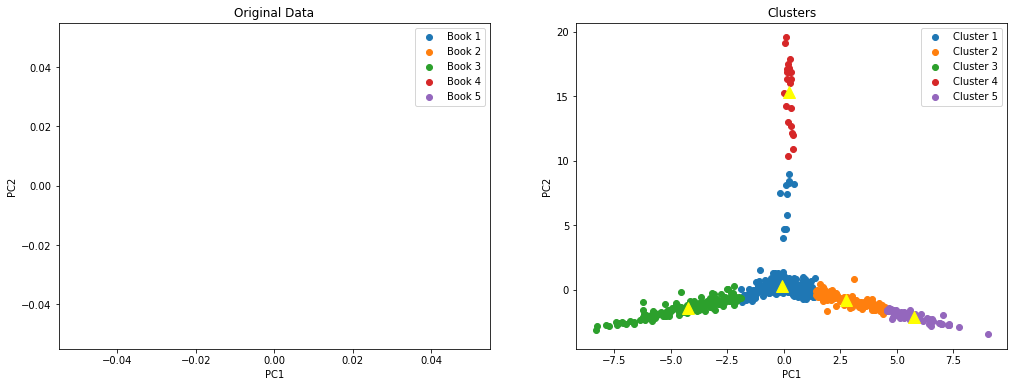

In [ ]:
label =agg_bow_model.labels_
data =bow_model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(2)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(1)
  elif yy[i]=="d":
    x.append(3)
  else :
    x.append(4)

print("Accuracy equal :-> ",np.mean(label == x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(data , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

plot_clusters(bow_model, agg_bow_model, y)

In [ ]:
#calc_scores(bow_model, agg_bow_model, y)

### TF-IDF

In [ ]:
tfidf_model, tfidf_vectorizer = tfidf_transform(books_df.Paragraphs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


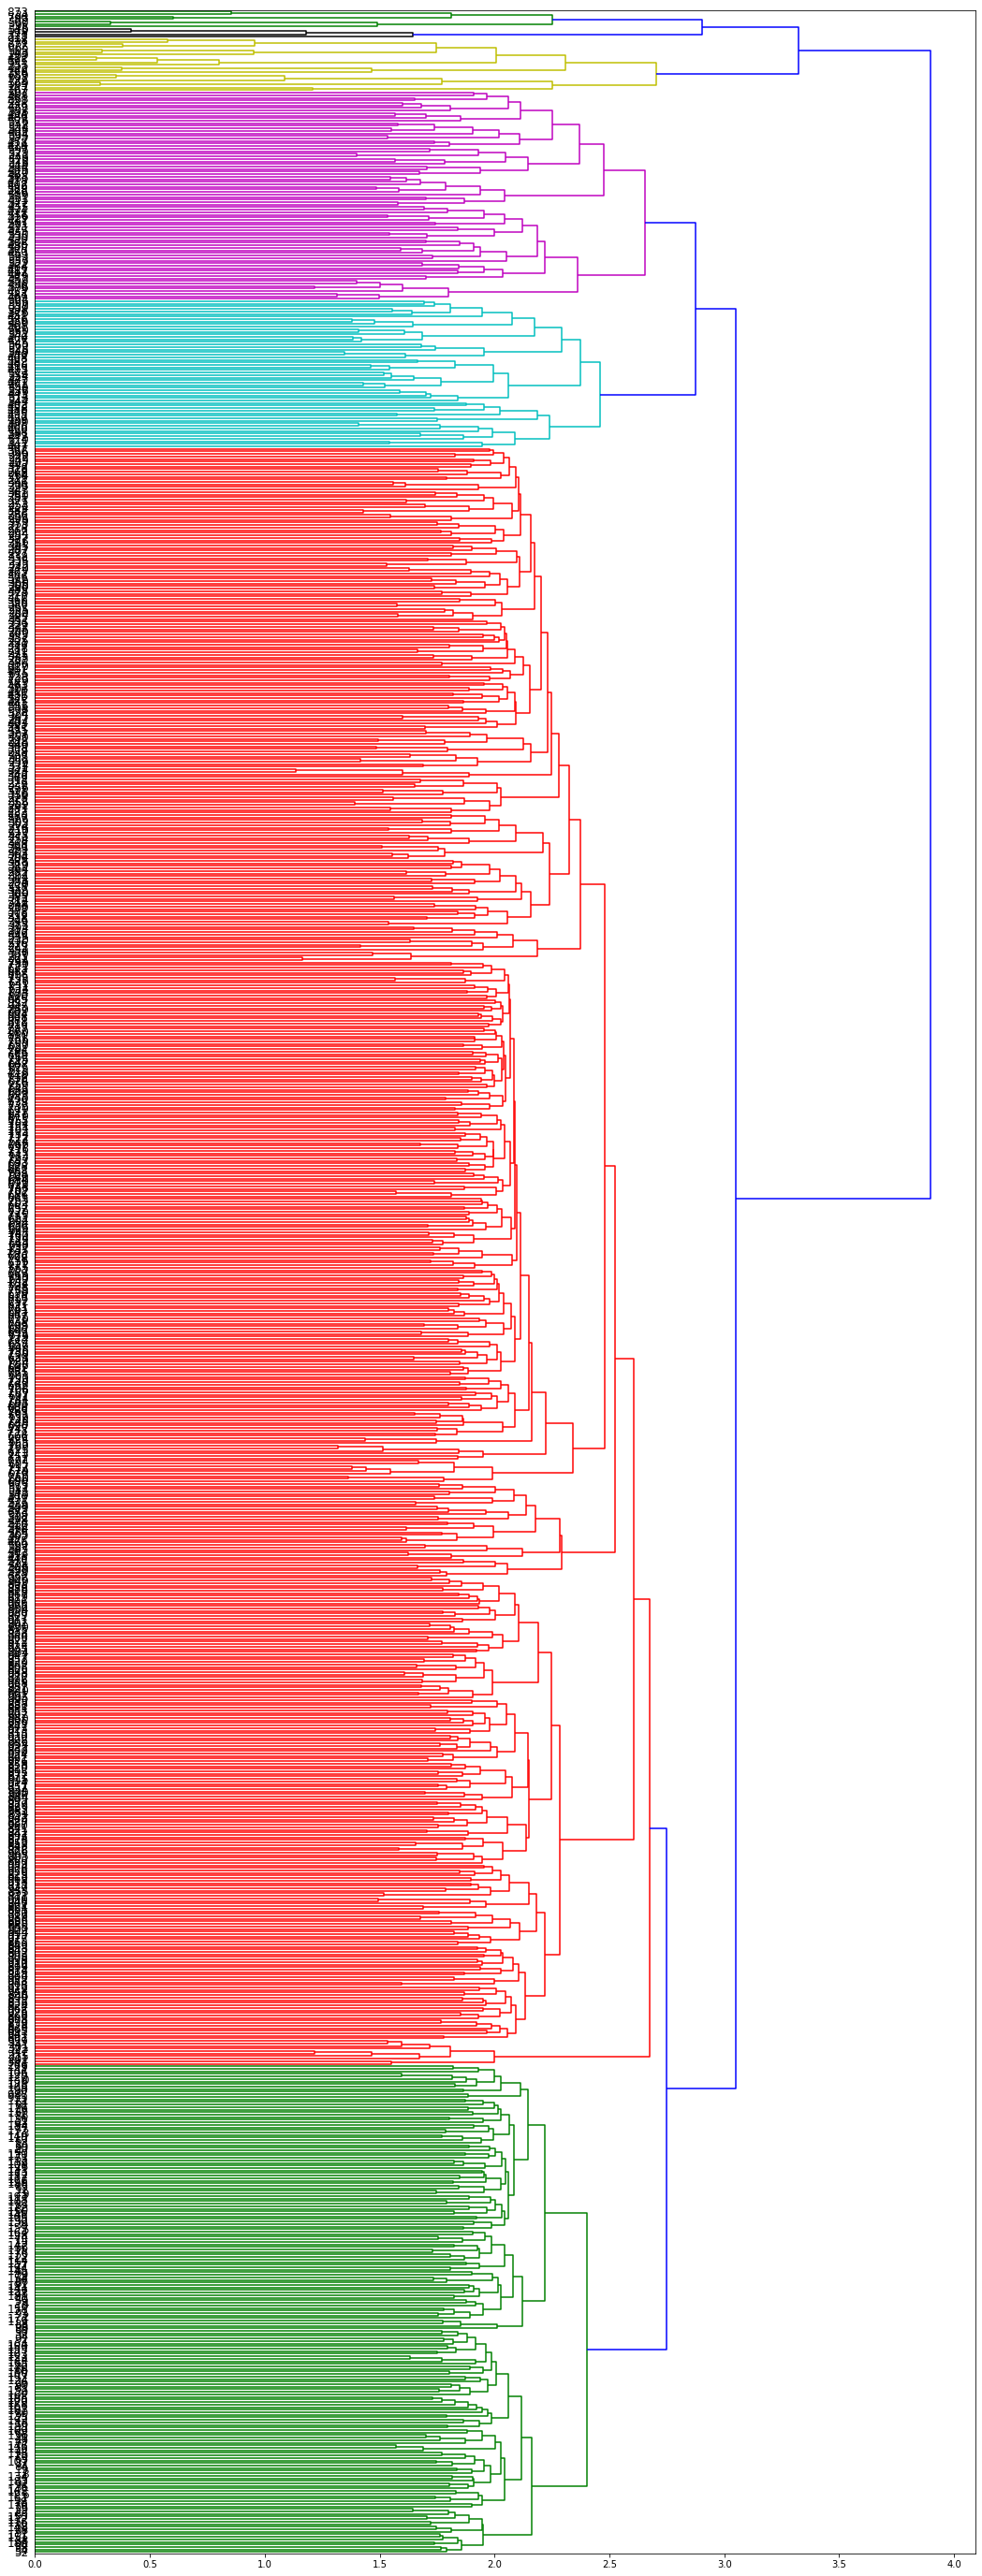

In [ ]:
draw_dendo(dist_matrix(tfidf_model))

In [ ]:
agg_tfidf_model = AgglomerativeClustering(n_clusters=5).fit(tfidf_model.toarray(), y)
#agg_tfidf_model



Accuracy equal :->  0.768
              precision    recall  f1-score   support

           a       0.49      0.93      0.64       200
           b       0.99      0.97      0.98       200
           c       0.09      0.01      0.03       200
           d       1.00      0.95      0.97       200
           e       0.98      0.97      0.98       200

    accuracy                           0.77      1000
   macro avg       0.71      0.77      0.72      1000
weighted avg       0.71      0.77      0.72      1000

Kappa for the model :->  0.71
For n_clusters = 5 The average silhouette_score : 0.02716540131719657
For n_clusters = 5 The average homogeneity_score : 0.7778623341400672
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2 3 3 3 3
 3 3 3 3 3 2 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


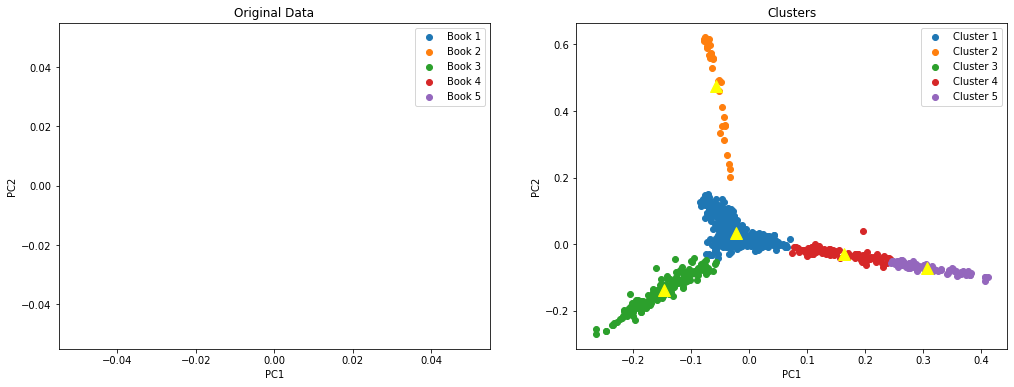

In [ ]:
label =agg_tfidf_model.labels_
data =tfidf_model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(3)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(1)
  elif yy[i]=="d":
    x.append(2)
  else :
    x.append(4)

print("Accuracy equal :-> ",np.mean(label == x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(data , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

plot_clusters(tfidf_model, agg_tfidf_model, y)

In [ ]:
#calc_scores(tfidf_model, agg_tfidf_model, y)

### Try Train Test Split

In [ ]:
X = books_df.Paragraphs
y = books_df.label_num

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
bow_train = vectorizer.fit_transform(X_train)


In [ ]:
tr_tfidf_model, tr_tfidf_vectorizer = tfidf_transform(X_train)

In [ ]:
tr_tfidf_model

<800x18066 sparse matrix of type '<class 'numpy.float64'>'
	with 92660 stored elements in Compressed Sparse Row format>

In [ ]:
tr_tfidf_vectorizer.transform(X_test)

<200x18066 sparse matrix of type '<class 'numpy.float64'>'
	with 20928 stored elements in Compressed Sparse Row format>

In [ ]:
tt_agg_tfidf_model = AgglomerativeClustering(n_clusters=5).fit(tr_tfidf_model.toarray(), y_train)
tt_agg_tfidf_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

In [ ]:
tt_agg_tfidf_model.fit_predict(tr_tfidf_vectorizer.transform(X_test).toarray())

array([2, 0, 0, 0, 2, 0, 0, 2, 0, 4, 0, 4, 0, 0, 0, 0, 1, 0, 0, 1, 2, 4,
       1, 2, 1, 1, 4, 0, 0, 0, 3, 4, 0, 2, 1, 0, 0, 2, 0, 4, 1, 4, 1, 0,
       1, 1, 0, 0, 2, 0, 2, 0, 1, 2, 4, 4, 0, 4, 1, 0, 1, 4, 2, 3, 0, 0,
       0, 0, 4, 2, 4, 2, 2, 0, 1, 1, 0, 4, 2, 1, 0, 4, 1, 4, 1, 2, 0, 0,
       0, 1, 1, 2, 2, 0, 0, 2, 0, 4, 4, 0, 0, 1, 0, 1, 0, 0, 2, 0, 3, 0,
       2, 0, 0, 0, 4, 2, 4, 3, 2, 1, 0, 2, 0, 1, 1, 2, 2, 2, 0, 0, 2, 0,
       1, 0, 2, 4, 4, 2, 4, 4, 4, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 4, 0, 2,
       0, 2, 1, 0, 4, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 4, 0, 2, 1,
       1, 1, 0, 0, 2, 0, 1, 2, 0, 4, 3, 3, 0, 0, 0, 0, 0, 4, 1, 2, 1, 1,
       0, 4])

In [ ]:
y_test.to_numpy()

array([2, 3, 3, 3, 2, 3, 3, 2, 4, 0, 4, 0, 3, 4, 4, 4, 1, 4, 3, 1, 2, 0,
       1, 2, 1, 1, 0, 4, 4, 4, 1, 0, 3, 2, 1, 0, 3, 2, 4, 0, 1, 0, 1, 4,
       1, 1, 4, 3, 2, 4, 2, 4, 1, 2, 0, 0, 3, 0, 1, 4, 1, 0, 2, 1, 3, 3,
       3, 4, 0, 2, 0, 2, 2, 3, 1, 1, 3, 0, 2, 1, 3, 0, 1, 0, 1, 2, 4, 3,
       3, 1, 1, 2, 2, 1, 3, 2, 3, 0, 0, 4, 3, 1, 4, 1, 3, 3, 2, 4, 0, 4,
       2, 4, 4, 4, 0, 2, 0, 4, 2, 1, 4, 2, 3, 1, 1, 2, 2, 2, 4, 4, 2, 4,
       1, 4, 2, 0, 0, 1, 0, 0, 0, 1, 3, 1, 4, 4, 4, 1, 4, 1, 3, 0, 4, 2,
       4, 2, 1, 3, 0, 4, 2, 3, 3, 3, 4, 3, 1, 3, 1, 1, 1, 2, 0, 4, 2, 1,
       1, 1, 4, 3, 2, 3, 1, 2, 4, 0, 1, 1, 4, 3, 4, 4, 3, 0, 1, 2, 1, 1,
       3, 0])

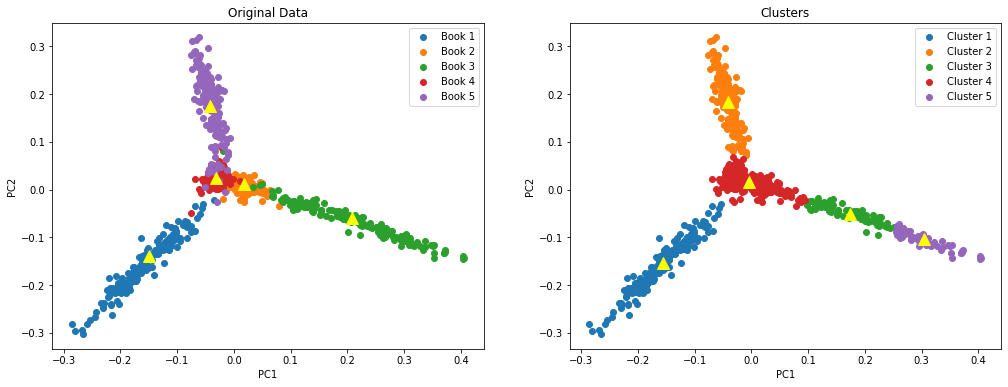

In [ ]:
plot_clusters(tr_tfidf_model, tt_agg_tfidf_model, y_train)

In [ ]:
calc_scores(tr_tfidf_model, tt_agg_tfidf_model, y_train)

Silhouette Coefficient is: 0.027
Cohen’s kappa Score is: -0.0411


---


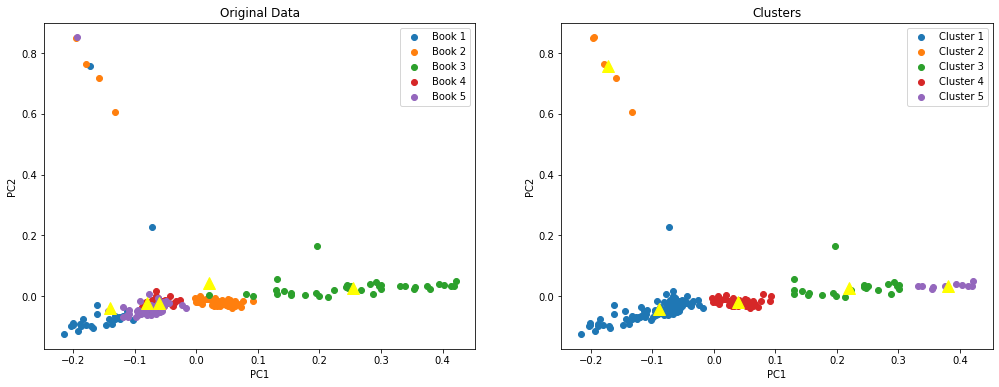

In [ ]:
plot_clusters(tr_tfidf_vectorizer.transform(X_test), tt_agg_tfidf_model, y_test)

In [ ]:
calc_scores(tr_tfidf_vectorizer.transform(X_test), tt_agg_tfidf_model, y_test)

Silhouette Coefficient is: 0.032
Cohen’s kappa Score is: 0.2557


---

### LDA

LDA + BoW

In [ ]:
lda_bow_model, lda_vectorizer = lda_transform(bow_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


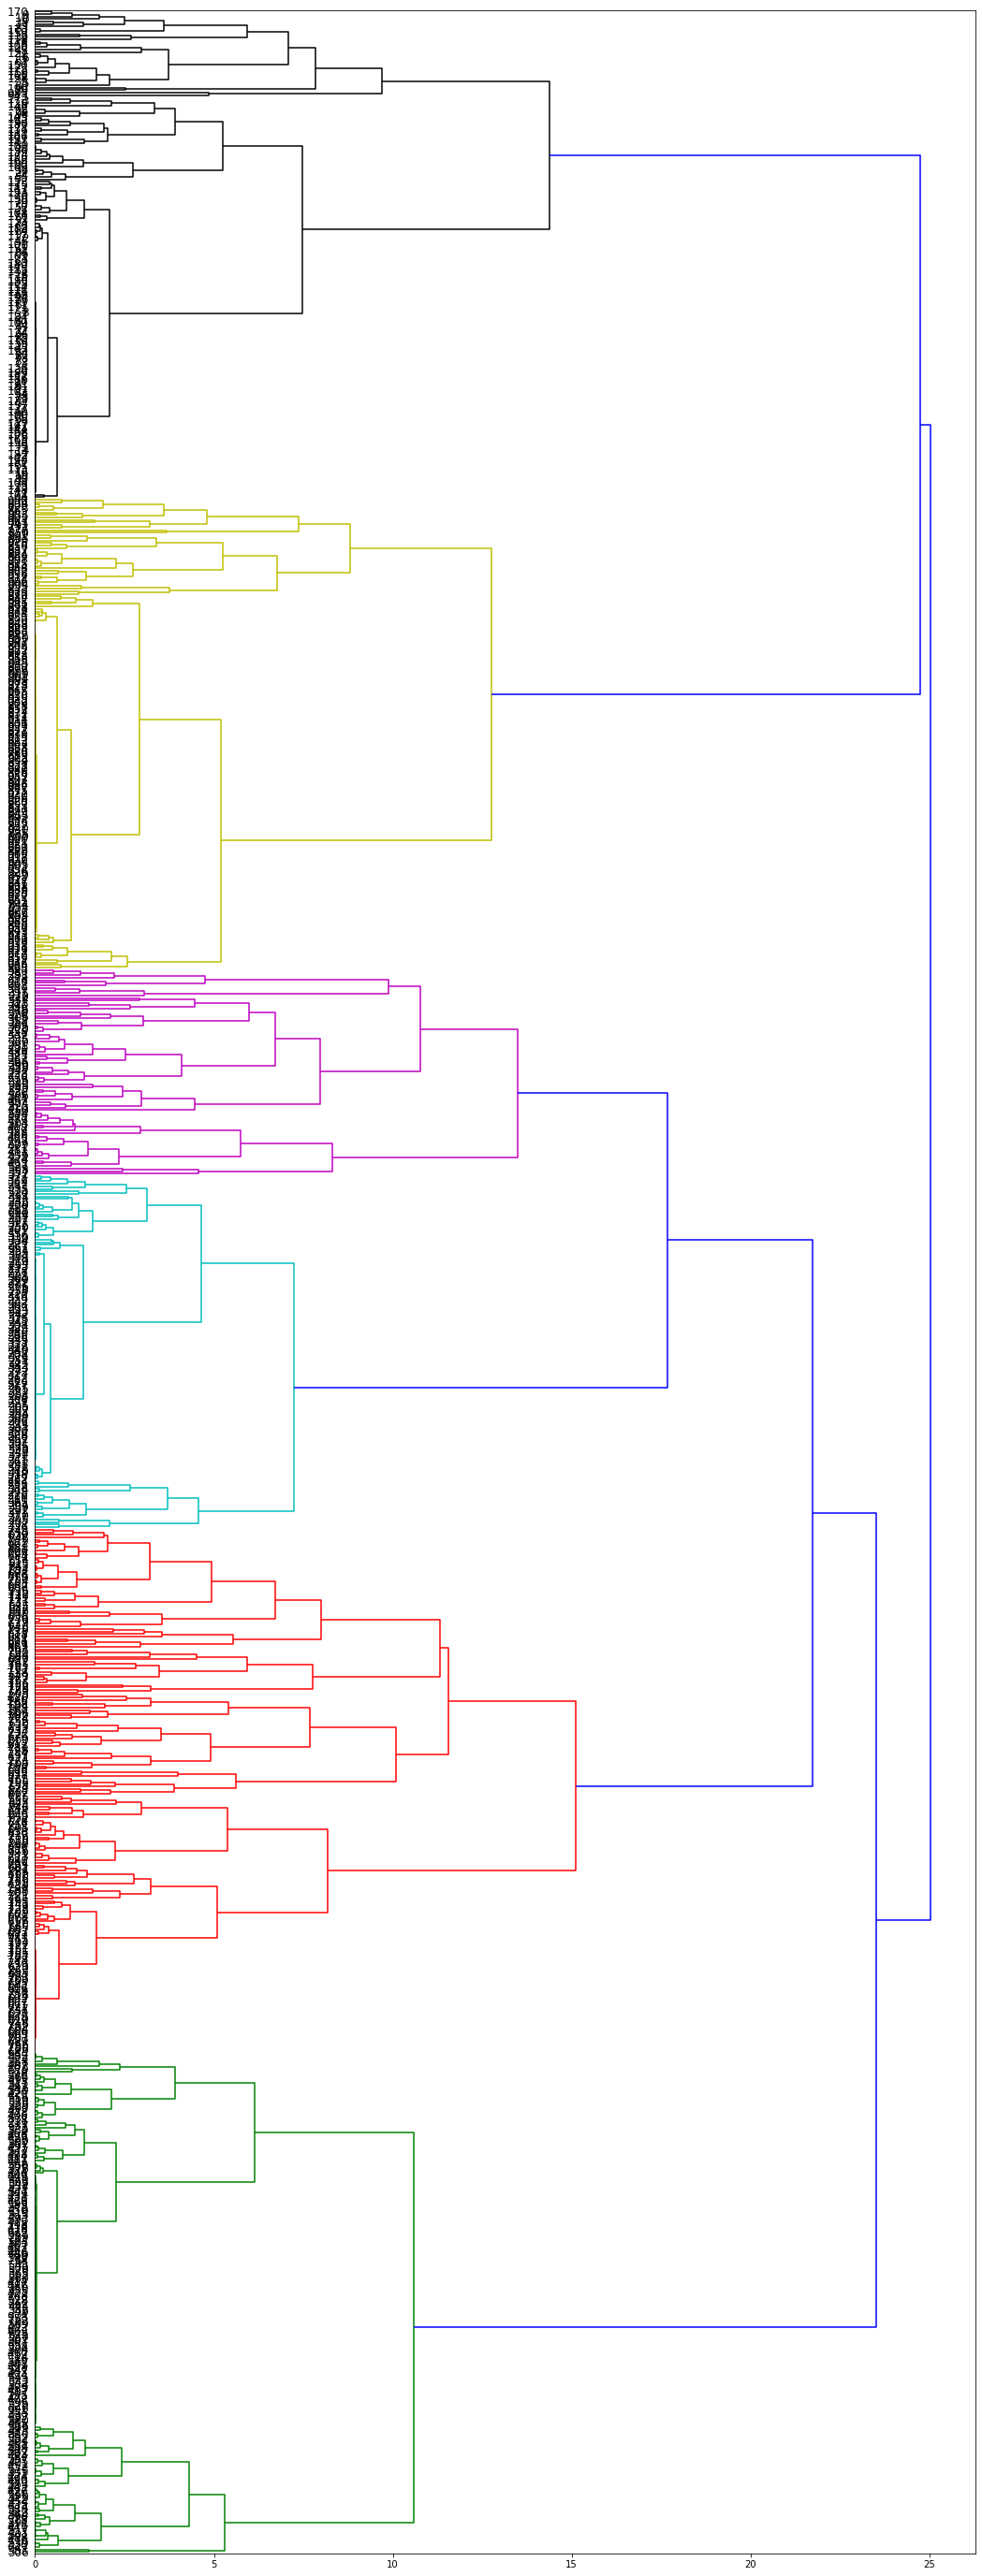

In [ ]:
draw_dendo(dist_matrix(lda_bow_model))

In [ ]:
agg_lda_bow_model = AgglomerativeClustering(n_clusters=5).fit(lda_bow_model.toarray(), y)
#agg_lda_bow_model



Accuracy equal :->  0.933
              precision    recall  f1-score   support

           a       0.86      0.95      0.91       200
           b       0.90      0.96      0.93       200
           c       0.99      0.93      0.96       200
           d       0.95      0.91      0.93       200
           e       0.98      0.91      0.94       200

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000

Kappa for the model :->  0.91625
For n_clusters = 5 The average silhouette_score : 0.7234384224484725
For n_clusters = 5 The average homogeneity_score : 0.8205371243843882
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2
 2 2 2 2 2 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


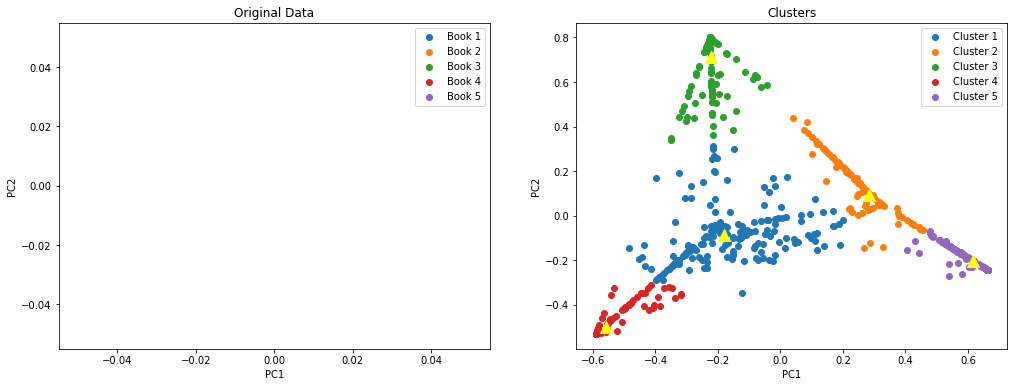

In [ ]:
label =agg_lda_bow_model.labels_
data =lda_bow_model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(2)
  elif yy[i]=="b":
    x.append(3)
  elif yy[i]=="c":
    x.append(0)
  elif yy[i]=="d":
    x.append(1)
  else :
    x.append(4)

print("Accuracy equal :-> ",np.mean(label == x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(data , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

plot_clusters(lda_bow_model, agg_lda_bow_model, y)

In [ ]:
#calc_scores(lda_bow_model, agg_lda_bow_model, y)

LDA + TF-IDF

In [ ]:
lda_tfidf_model, lda_tfidf_vectorizer = lda_transform(tfidf_model)

In [ ]:
len(lda_tfidf_vectorizer.components_[1])

19913

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


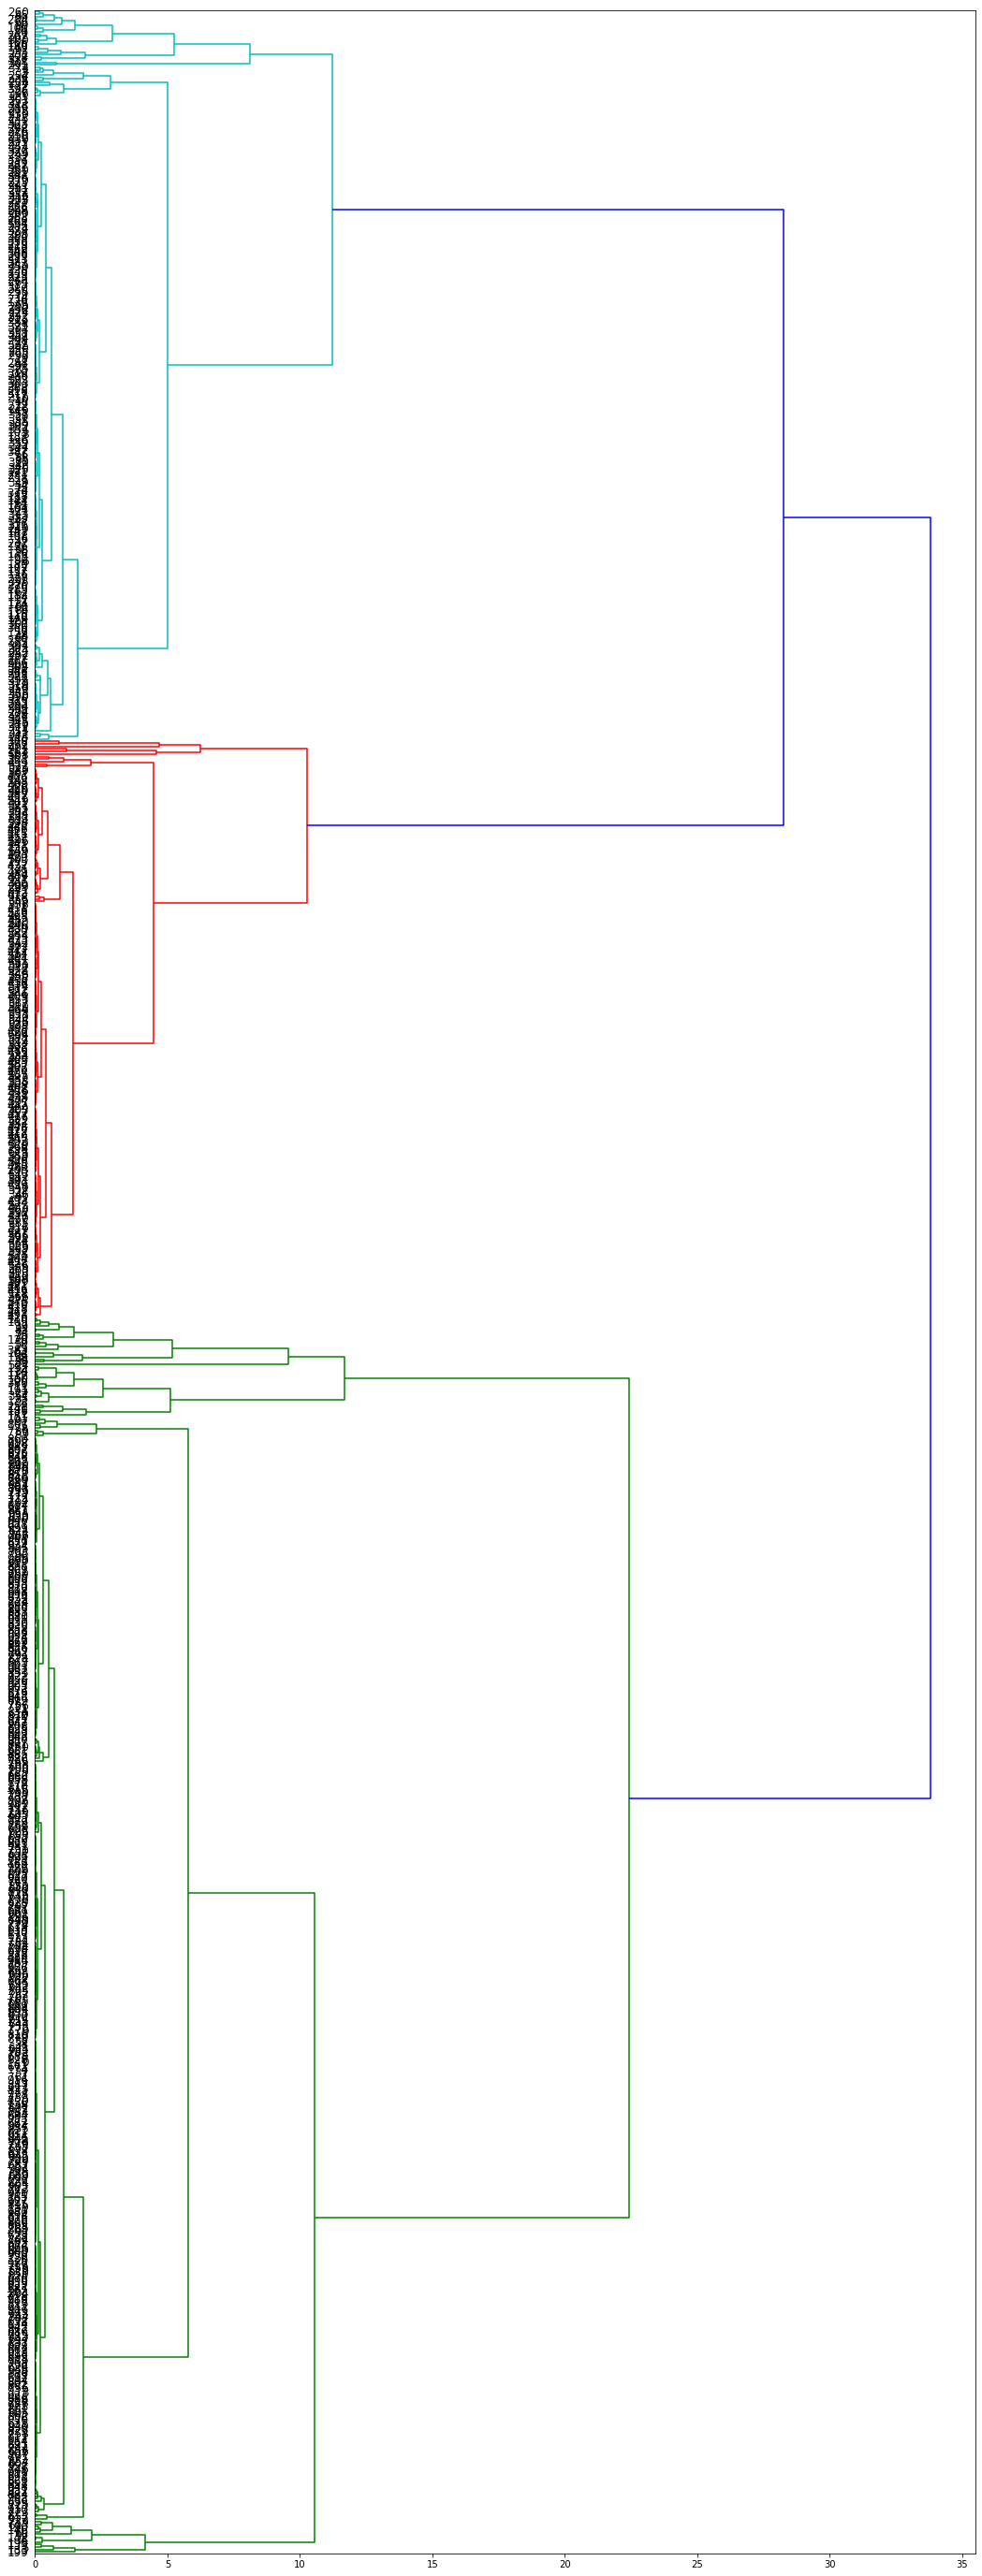

In [ ]:
draw_dendo(dist_matrix(lda_tfidf_model))

In [ ]:
agg_lda_tfidf_model = AgglomerativeClustering(n_clusters=5).fit(lda_tfidf_model.toarray(), y)
#agg_lda_tfidf_model



Accuracy equal :->  0.598
              precision    recall  f1-score   support

           a       0.44      0.98      0.61       200
           b       0.87      0.17      0.28       200
           c       0.88      0.99      0.93       200
           d       0.00      0.00      0.00       200
           e       0.67      0.84      0.75       200

    accuracy                           0.60      1000
   macro avg       0.57      0.60      0.51      1000
weighted avg       0.57      0.60      0.51      1000

Kappa for the model :->  0.49750000000000005
For n_clusters = 5 The average silhouette_score : 0.9133897377136565
For n_clusters = 5 The average homogeneity_score : 0.5285677797620357
[0 4 0 0 3 0 4 0 4 0 3 4 1 0 4 4 4 4 1 4 0 0 1 4 2 1 3 4 4 4 1 2 4 3 1 1 0
 0 0 1 4 4 4 0 0 3 0 4 4 4 1 4 0 4 4 4 4 0 4 1 4 3 4 4 4 4 3 0 4 0 0 1 4 4
 4 1 4 1 0 4 3 4 4 1 1 1 4 0 4 1 4 4 3 0 1 2 0 0 1 3 3 0 3 4 1 0 1 0 4 1 1
 4 3 1 4 4 4 1 4 0 0 3 1 4 4 0 4 4 4 1 1 0 4 0 0 4 4 4 2 0 4 1 0 2 4 4 0 4

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


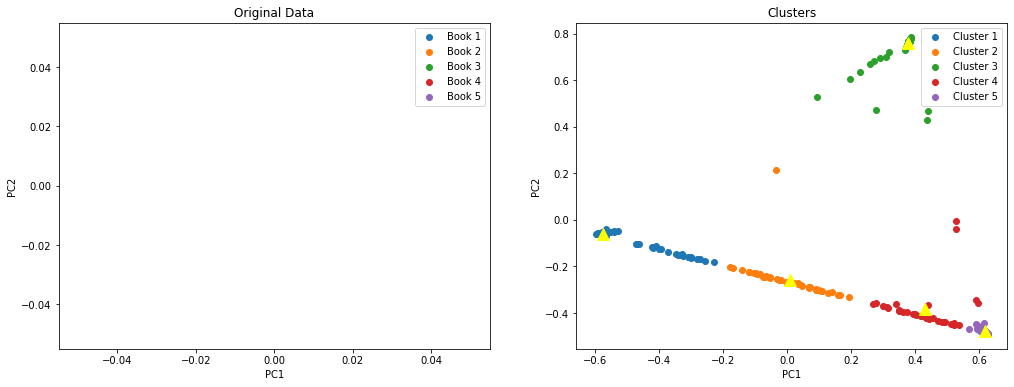

In [ ]:
label =agg_lda_tfidf_model.labels_
data =lda_tfidf_model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(1)
  elif yy[i]=="b":
    x.append(4)
  elif yy[i]=="c":
    x.append(2)
  elif yy[i]=="d":
    x.append(0)
  else :
    x.append(3)

print("Accuracy equal :-> ",np.mean(label == x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(data , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

plot_clusters(lda_tfidf_model, agg_lda_tfidf_model, y)

In [ ]:
#calc_scores(lda_tfidf_model, agg_lda_tfidf_model, y)

In [ ]:
from gensim.test.utils import common_corpus, common_dictionary


In [ ]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [ ]:
print(common_dictionary.token2id)

{'computer': 0, 'human': 1, 'interface': 2, 'response': 3, 'survey': 4, 'system': 5, 'time': 6, 'user': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


In [ ]:
# import gensim
# from gensim import corpora
# from pprint import pprint
# doc = [
#    "CNTK formerly known as Computational Network Toolkit",
#    "is a free easy-to-use open-source commercial-grade toolkit",
#    "that enable us to train deep learning algorithms to learn like the human brain."
# ]
# text_tokens = [[text for text in doc.split()] for doc in doc]
# dict_LoS = corpora.Dictionary(text_tokens)
# print(dict_LoS.token2id)

In [ ]:
# from gensim.models.coherencemodel import CoherenceModel

# topics = [
#     ['human', 'computer', 'system', 'interface'],
#     ['graph', 'minors', 'trees', 'eps']
#   ]

# cm = CoherenceModel( topics= topics,corpus=common_corpus,dictionary=common_dictionary,coherence='u_mass')
# coherence = cm.get_coherence()
# coherence

### Word Embedding

In [ ]:
type(d2v)

numpy.ndarray

In [ ]:
d2v_sparse = sparse.csr_matrix(d2v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


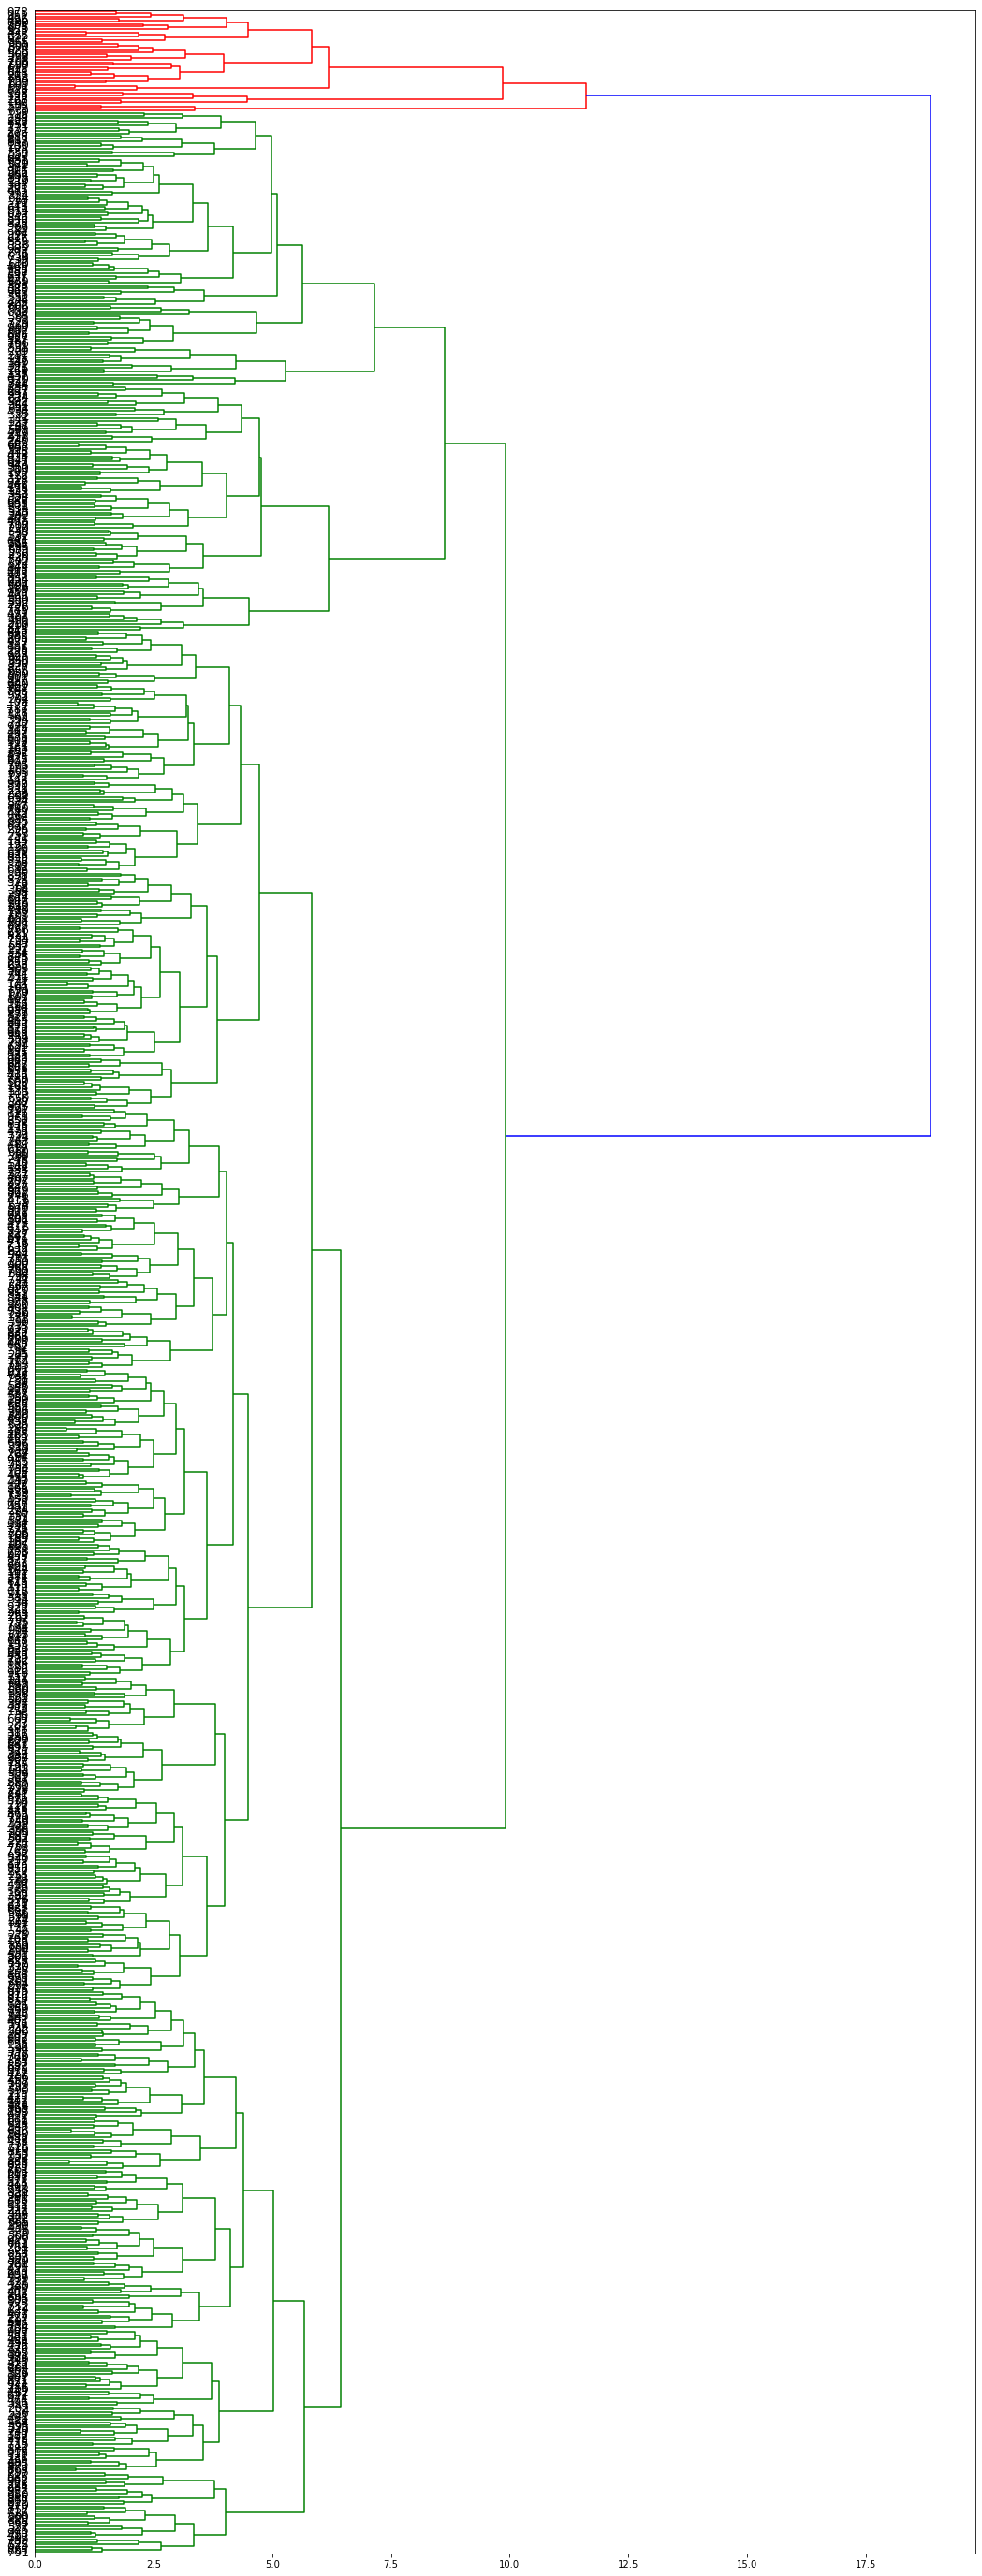

In [ ]:
draw_dendo(dist_matrix(d2v_sparse))

In [ ]:
agg_doc2vec_model = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(d2v_sparse.toarray(), y)
#agg_doc2vec_model



Accuracy equal :->  0.179
              precision    recall  f1-score   support

           a       0.18      0.09      0.12       200
           b       0.15      0.40      0.22       200
           c       0.21      0.34      0.26       200
           d       0.27      0.07      0.11       200
           e       0.00      0.00      0.00       200

    accuracy                           0.18      1000
   macro avg       0.16      0.18      0.14      1000
weighted avg       0.16      0.18      0.14      1000

Kappa for the model :->  -0.026250000000000107
For n_clusters = 5 The average silhouette_score : 0.032621246
For n_clusters = 5 The average homogeneity_score : 0.019299569482591195
[1 0 1 2 2 2 2 0 2 1 1 1 2 2 0 2 2 1 1 2 2 1 2 0 3 2 2 1 1 0 2 1 2 1 2 2 2
 1 2 2 2 2 2 2 1 2 1 2 2 2 1 1 1 1 2 2 0 3 1 1 2 1 2 0 2 2 1 1 1 1 1 0 1 0
 0 1 3 1 1 1 2 2 0 1 2 1 1 1 1 0 2 2 2 2 2 3 2 0 1 1 2 1 0 0 2 1 2 2 2 1 1
 1 2 1 1 1 2 2 1 2 1 3 3 0 1 3 2 1 1 1 2 2 0 2 0 1 2 1 1 3 1 1 2 1 1 1 2 2
 2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


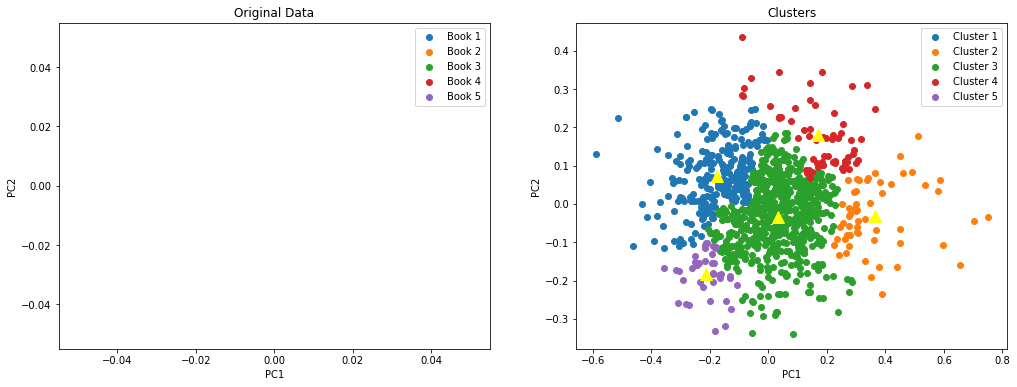

In [ ]:
label =agg_doc2vec_model.labels_
data =d2v
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(1)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(3)
  elif yy[i]=="d":
    x.append(2)
  else :
    x.append(4)

print("Accuracy equal :-> ",np.mean(label == x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(data , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

plot_clusters(d2v_sparse, agg_doc2vec_model, y)

In [ ]:
#calc_scores(d2v_sparse, agg_doc2vec_model, y)